#### Описание проекта
<b>Проект</b>:<br> 
Анализ оттока клиентов банка

<b>Цели проекта:</b><br>
- выполнить анализ данных о клиентах регионального банка<br>
- провести исследовательский анализ данных, определить все значимые признаки отточности (интервалы значений характеристик, которые связаны с повышенным оттоком, сравнить портреты типичных клиентов, которые склонны и не склонны уходить из банка)<br>
- сформулировать и проверить статистические гипотезы<br>
- выделить сегменты клиентов, которые склонны уходить из банка<br>
- сделать выводы и дать рекомендации<br>

In [1]:
! pip install phik

     |████████████████████████████████| 686 kB 1.2 MB/s eta 0:00:01


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import phik
import seaborn as sns
from scipy import stats as st

In [3]:
pd.set_option('display.max_colwidth', None)

plt.style.use('seaborn-pastel')

#### Шаг 1. Общая нформация в файле с данными

In [4]:
data = pd.read_csv('/datasets/bank_scrooge.csv')
data

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,120553,814.0,Рыбинск,М,27.0,1,78144.65,1,0,1,18943.64,0
9996,139170,894.0,Ярославль,М,46.0,0,NaN,1,1,0,196898.29,0
9997,115639,903.0,Ярославль,М,24.0,0,NaN,2,1,1,108905.09,0
9998,148700,777.0,Ярославль,Ж,68.0,3,865457.97,3,0,1,86874.90,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


In [6]:
data_count = data.shape[0]

Данных 10000 строк, есть пропущенные значения в столбцах возраста и баланса.<br>
Тип float у столбцов с данными рейтинга (можем изменить на int, т.к. это целые числа), возраста (т.к. есть пропущенные значения), баланса и дохода.<br>
Тип int у столбцов с идентификаторами клиентов, количеством баллов собственности, количеством продуктов, признаками кредитной карты, недавней активности и оттока (у признаков значения 0 и 1).<br>
Тип object у столбцов города и возраста.<br> 

#### Шаг 2. Предобработка данных

In [7]:
data = data.rename(columns={'USERID': 'user_id', 'EST_SALARY': 'est_salary'})

In [8]:
data.isna().sum()

user_id             0
score               0
city                0
gender              0
age                26
equity              0
balance          2295
products            0
credit_card         0
last_activity       0
est_salary          0
churn               0
dtype: int64

In [9]:
data.isna().sum() / data_count * 100

user_id           0.00
score             0.00
city              0.00
gender            0.00
age               0.26
equity            0.00
balance          22.95
products          0.00
credit_card       0.00
last_activity     0.00
est_salary        0.00
churn             0.00
dtype: float64

Есть пропуски в столбце о возрасте (0.26%) и много пропусков (23%) в столбце о балансе, далее проведем анализ пропусков

In [10]:
# приведение баллов кредитного скоринга в целый тип
data['score'] = data['score'].astype(int)
data.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,183012,850,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


In [11]:
# признак уходящих/не уходящих
data['churn_name'] = data['churn'].apply(lambda x: 'уходящий' if x == 1 else 'не уходящий')

##### Проверка содержащихся в столбцах данных

In [12]:
#количество уникальных user_id
id_count = len(data['user_id'].unique())
id_count

9927

Необходимо будет проверить далее данные в user_id, т.к. количество уникальных id отличается от количества данных всего

In [13]:
data.describe(percentiles=[])[3:6]

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
min,94561.0,642.0,18.0,0.0,0.000000e+00,0.0,0.0,0.0,2546.300,0.0
50%,172728.0,853.0,40.0,3.0,5.242722e+05,2.0,1.0,1.0,119658.105,0.0
max,229145.0,1000.0,86.0,9.0,1.191136e+08,5.0,1.0,1.0,1395064.450,1.0


Минимумы и максимумы значений корректны.

In [14]:
data['city'].unique()

array(['Рыбинск', 'Ярославль', 'Ростов'], dtype=object)

In [15]:
data['gender'].unique()

array(['Ж', 'М'], dtype=object)

In [16]:
# пол в числовое значение
data['gender_num'] = data['gender'].apply(lambda x: 1 if x == 'М' else 0)
data.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,churn_name,gender_num
0,183012,850,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,уходящий,0
1,146556,861,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,не уходящий,0
2,120722,892,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,не уходящий,0
3,225363,866,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,уходящий,0
4,157978,730,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,уходящий,1


In [17]:
data['churn'].unique()

array([1, 0])

In [18]:
sorted(data['products'].unique())

[0, 1, 2, 3, 4, 5]

In [19]:
data[data['products'] == 0]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,churn_name,gender_num
8957,147837,962,Рыбинск,Ж,79.0,3,NaN,0,0,0,25063.96,1,уходящий,0


У одного клиента указано некорректное количество продуктов, удалим эту строку:

In [20]:
data = data[data['products'] != 0]
data.shape[0]

9999

In [21]:
sorted(data['equity'].unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [22]:
data['last_activity'].unique()

array([1, 0])

In [23]:
data['credit_card'].unique()

array([0, 1])

В данных была одна строка со значением 0 в столбце products - некорреткно, строка удалена. <br>
Остальные значения, содержащиеся в столбцах датасета, корректны.

##### Проверка на дубликаты

In [24]:
data.duplicated().sum()

0

Явных дублей нет

In [25]:
# группировка по user_id
data_grouped = data.groupby('user_id', as_index=False).agg({'score':'count'})
data_grouped.columns = ['user_id', 'count']
# data_grouped.sort_val 0ues(by=['count'], ascending=False).head(50)
data_grouped = data_grouped[data_grouped['count'] > 1]
data_grouped

,user_id,count
262,116540,2
392,117943,2
590,120258,2
885,123461,2
981,124450,2
...,...,...
9347,222480,2
9680,226550,2
9705,226719,2
9804,227795,2


In [26]:
data_grouped.reset_index().merge(data, on=['user_id'], how='left')

,index,user_id,count,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,churn_name,gender_num
0,262,116540,2,883,Рыбинск,Ж,55.0,1,362756.49,3,0,1,175920.48,1,уходящий,0
1,262,116540,2,887,Ярославль,Ж,38.0,0,NaN,1,0,1,119247.61,0,не уходящий,0
2,392,117943,2,855,Рыбинск,Ж,32.0,6,1036832.93,4,1,1,107792.71,1,уходящий,0
3,392,117943,2,880,Ярославль,Ж,40.0,0,NaN,1,1,0,137718.93,0,не уходящий,0
4,590,120258,2,908,Рыбинск,Ж,38.0,4,2213581.63,2,0,1,160327.77,1,уходящий,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,9705,226719,2,903,Рыбинск,Ж,63.0,0,NaN,1,1,0,138582.58,0,не уходящий,0
142,9804,227795,2,840,Рыбинск,М,34.0,2,350768.03,1,1,0,102036.14,1,уходящий,1
143,9804,227795,2,839,Ярославль,М,34.0,2,326593.14,2,1,0,103314.92,0,не уходящий,1
144,9836,228075,2,932,Ярославль,М,NaN,5,7601719.20,2,1,1,408121.16,0,не уходящий,1


In [27]:
data[data.duplicated(['user_id'], keep=False)].sort_values(by='user_id')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,churn_name,gender_num
1893,116540,883,Рыбинск,Ж,55.0,1,362756.49,3,0,1,175920.48,1,уходящий,0
7694,116540,887,Ярославль,Ж,38.0,0,NaN,1,0,1,119247.61,0,не уходящий,0
7542,117943,880,Ярославль,Ж,40.0,0,NaN,1,1,0,137718.93,0,не уходящий,0
4866,117943,855,Рыбинск,Ж,32.0,6,1036832.93,4,1,1,107792.71,1,уходящий,0
5896,120258,905,Ярославль,М,30.0,0,NaN,1,1,1,146427.96,0,не уходящий,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2597,226719,990,Ярославль,М,37.0,4,14648692.14,2,0,0,934412.61,1,уходящий,1
8205,227795,840,Рыбинск,М,34.0,2,350768.03,1,1,0,102036.14,1,уходящий,1
8497,227795,839,Ярославль,М,34.0,2,326593.14,2,1,0,103314.92,0,не уходящий,1
6457,228075,839,Рыбинск,М,39.0,5,507199.85,3,0,1,85195.80,0,не уходящий,1


In [28]:
data_grouped = data.groupby(['user_id', 'city'], as_index=False).agg({'score':'count'})
data_grouped.columns = ['user_id', 'city', 'count']
data_grouped = data_grouped[data_grouped['count'] > 1]
data_grouped

,user_id,city,count


Есть повторения в user_id, но это пользователи в разных городах, в одном городе user_id не повторяются, дублей нет

##### Проверка пропущенных значений

In [29]:
data[data['age'].isna()]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,churn_name,gender_num
1247,228075,932,Ярославль,М,NaN,5,7601719.20,2,1,1,408121.16,0,не уходящий,1
2165,187635,692,Рыбинск,Ж,NaN,0,NaN,1,1,1,160368.82,0,не уходящий,0
2444,221156,913,Ярославль,М,NaN,0,NaN,1,1,1,135693.24,0,не уходящий,1
3091,138660,836,Ростов,Ж,NaN,5,294315.53,2,0,1,63310.22,1,уходящий,0
4912,210674,834,Рыбинск,М,NaN,1,238330.52,2,0,1,93775.06,0,не уходящий,1
5470,218868,827,Рыбинск,Ж,NaN,4,448959.07,2,1,1,67835.95,0,не уходящий,0
5495,151662,884,Рыбинск,Ж,NaN,0,NaN,1,1,1,137500.77,0,не уходящий,0
7236,210135,908,Рыбинск,Ж,NaN,4,1120340.31,3,1,1,85002.15,0,не уходящий,0
7248,219343,920,Рыбинск,Ж,NaN,0,NaN,1,1,0,159248.67,0,не уходящий,0
7345,184913,829,Ярославль,Ж,NaN,3,188648.77,2,0,1,75206.90,0,не уходящий,0


In [30]:
data[data['balance'].isna()].head(20)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,churn_name,gender_num
2,120722,892,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,не уходящий,0
9,133130,906,Ярославль,Ж,67.0,0,NaN,1,0,1,238055.53,0,не уходящий,0
10,148929,927,Ростов,М,52.0,0,NaN,1,1,1,196820.07,0,не уходящий,1
11,172184,921,Ростов,М,41.0,0,NaN,1,1,1,217469.48,0,не уходящий,1
19,127034,922,Рыбинск,Ж,53.0,0,NaN,1,0,0,147094.82,0,не уходящий,0
21,177415,896,Рыбинск,Ж,47.0,0,NaN,1,0,0,225060.35,0,не уходящий,0
30,155730,946,Ярославль,Ж,47.0,0,NaN,2,1,1,660015.85,0,не уходящий,0
34,205226,944,Ярославль,М,35.0,0,NaN,2,1,1,239843.39,0,не уходящий,1
39,173175,924,Рыбинск,Ж,51.0,0,NaN,1,1,1,248844.47,0,не уходящий,0
43,228585,956,Ростов,М,41.0,0,NaN,1,1,0,115117.10,0,не уходящий,1


###### Проверка пропущенных значений в балансе

In [31]:
data['null_balance'] = data['balance'].isna().astype(int)
data.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,churn_name,gender_num,null_balance
0,183012,850,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,уходящий,0,0
1,146556,861,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,не уходящий,0,0
2,120722,892,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,не уходящий,0,1
3,225363,866,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,уходящий,0,0
4,157978,730,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,уходящий,1,0


In [32]:
# меры центр. тенденции
measures_list = ['median', 'mean', pd.Series.mode]

# расчет мер центр. тендеции при группировке по полю оттока по значениям непрерывным и с большим количеством значений
def get_central_tendency_measures_churn(data, attr_groupby, attr_list, measures_list):
    
    central_tendency_measures = []   
    data_groupby = data.groupby(attr_groupby)
    
    for attr in attr_list:
        measures = [attr] 
        for measure in measures_list:
            try:    
                measure_0, measure_1 = None, None
                data_grouped = (data_groupby[attr]
                                .agg([measure])
                                .sort_values(by=attr_groupby, ascending=True)
                                .reset_index())                 
                measure_0, measure_1 = data_grouped.loc[0][1], data_grouped.loc[1][1]
            except:
                #print('error: ', attr, measure) 
                pass
            measures.extend([measure_0, measure_1])
                          
        central_tendency_measures.append(measures)    
    
    return central_tendency_measures


# расчет мер центр. тендеции по признакам
def get_central_tendency_measures(data, attr_groupby, attr_list, measures_list):
    
    central_tendency_measures = []   
    
    for attr in attr_list:
        measures = [attr] 
        for measure in measures_list:
            try:    
                measure_0, measure_1 = None, None
                data_grouped = (data.groupby(attr)[attr_groupby]
                                .agg([measure])
                                .sort_values(by=attr, ascending=True)
                                .reset_index())                 
                measure_0, measure_1 = data_grouped.loc[0][1], data_grouped.loc[1][1]
            except:
                #print('error: ', attr, measure)
                pass
            measures.extend([measure_0, measure_1])
                          
        central_tendency_measures.append(measures)    
    
    return central_tendency_measures

In [33]:
# расчет мер центр. тендеции при группировке по полю null_balance
attr_list = ['score', 'age', 'equity', 'products', 'est_salary', 'credit_card', 'last_activity', 'city', 'gender_num']
measures = get_central_tendency_measures(data, ['null_balance'], attr_list, measures_list)
measures = pd.DataFrame(measures, columns=['attr', 'median_notnull', 'median_null', 'mean_notnull', 'mean_null', 'mode_notnull', 'mode_null'])
measures['diff'] = measures.apply(lambda x: max(x['mean_notnull'], x['mean_null']) / min(x['mean_notnull'], x['mean_null']) if min(x['mean_notnull'], x['mean_null']) != 0 else None, axis=1)
measures.sort_values(by='diff', ascending = False)

,attr,median_notnull,median_null,mean_notnull,mean_null,mode_notnull,mode_null,diff
3,products,1.0,0.0,0.583658,0.061451,1.0,0.0,9.497869
2,equity,1.0,0.0,0.841049,0.147287,1.0,0.0,5.710283
5,credit_card,0.0,0.0,0.132081,0.275132,0.0,0.0,2.083051
1,age,1.0,0.0,0.615385,0.375000,1.0,0.0,1.641026
7,city,0.0,0.0,0.165843,0.219748,0.0,0.0,1.325031
8,gender_num,0.0,0.0,0.202643,0.256144,0.0,0.0,1.264014
6,last_activity,0.0,0.0,0.216835,0.240879,0.0,0.0,1.110887
0,score,1.0,1.0,1.000000,1.000000,1.0,1.0,1.000000
4,est_salary,0.0,0.0,0.000000,0.000000,0.0,0.0,NaN


In [34]:
# расчет мер центр. тендеции при группировке по полю null_balance
attr_list = ['score', 'age', 'equity', 'products', 'est_salary', 'credit_card', 'last_activity', 'city', 'gender_num']
measures = get_central_tendency_measures_churn(data, ['null_balance'], ['score', 'balance', 'est_salary', 'age'], measures_list)
measures = pd.DataFrame(measures, columns=['attr', 'median_notnull', 'median_null', 'mean_notnull', 'mean_null', 'mode_notnull', 'mode_null'])
measures['diff'] = measures.apply(lambda x: max(x['mean_notnull'], x['mean_null']) / min(x['mean_notnull'], x['mean_null']) if min(x['mean_notnull'], x['mean_null']) != 0 else None, axis=1)
measures.sort_values(by='diff', ascending = False)

,attr,median_notnull,median_null,mean_notnull,mean_null,mode_notnull,mode_null,diff
2,est_salary,106222.2,174202.8,124501.872366,226397.935876,NaN,None,1.818430
0,score,840.0,903.0,843.739260,865.309939,839.0,"[912, 913]",1.025566
3,age,40.0,40.0,42.924366,42.076822,36.0,36.0,1.020143
1,balance,524272.2,NaN,827794.306510,NaN,NaN,None,1.000000


Есть разница между средним по полю products в 9.5 раз, по полю equity в 5.7 раз, но наличию кредитной карты - в 2 раза, возрастом - 1.6 раз, а также доходом.

In [35]:
# количество продуктов у клиентов, по которым нет данных о балансе
data[data['balance'].isnull()]['products'].value_counts()

1    1950
2     315
3      29
Name: products, dtype: int64

In [36]:
# количество баллов собственности у клиентов, по которым неmт данных о балансе
data[data['balance'].isnull()]['equity'].value_counts()

0    2180
1     114
Name: equity, dtype: int64

Данные о балансе в основном отсутствуют у клиентов, у которых 0 или 1 балл собственности. Пропуски можно отнести к типу MNAR (Missing Not At Random / Отсутствует не случайно).

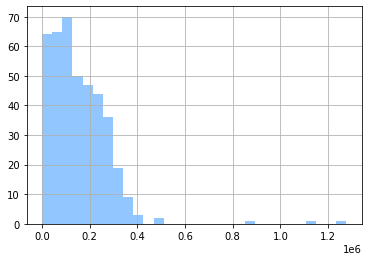

In [37]:
data[data['equity'] == 0]['balance'].hist(bins=30);

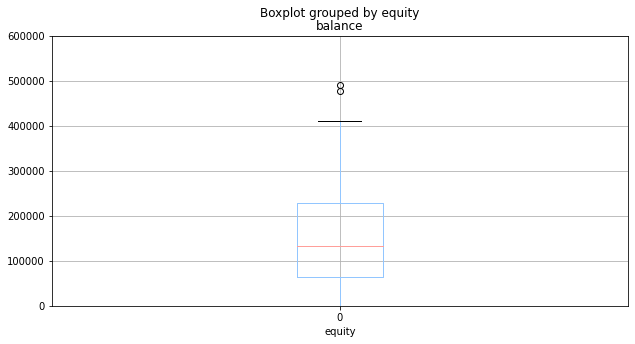

In [38]:
data[data['equity'] == 0].boxplot(column='balance', by='equity', figsize=(10, 5));
plt.ylim(0, 600000)
plt.show()

У клиентов с 0 баллами собственности медиана баланса примерно 150 тыс.

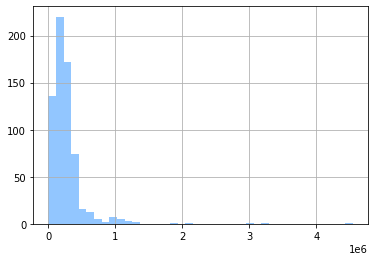

In [39]:
data[data['equity'] == 1]['balance'].hist(bins=40);

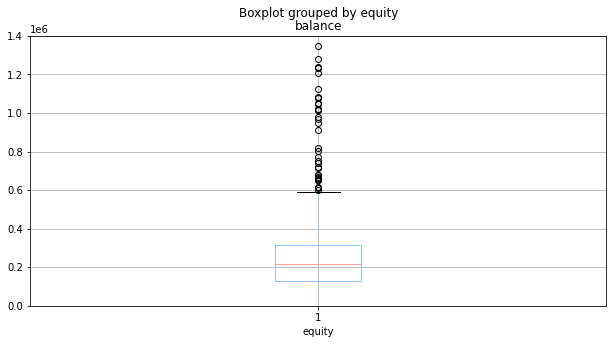

In [40]:
data[data['equity'] == 1].boxplot(column='balance', by='equity', figsize=(10, 5));
plt.ylim(0, 1400000)
plt.show()

У клиентов с 1 баллом собственности медиана баланса примерно 210 тыс.

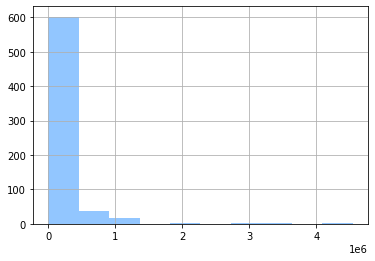

In [41]:
data[data['equity'] == 1]['balance'].hist();

<AxesSubplot:xlabel='equity'>

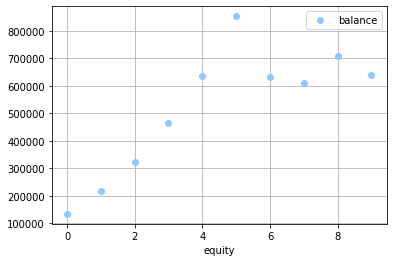

In [42]:
data_pivot = data.pivot_table(index='equity', values='balance', aggfunc='median')
data_pivot.plot(style='o', grid=True) 

In [43]:
data_pivot.reset_index().corr()

,equity,balance
equity,1.000000,0.807553
balance,0.807553,1.000000


Есть зависимость между балансом и баллами собственности- коэффициент корреляции 0.8.

</b><br>
Т.к. пропущенных значений много - почти 23%, удалить эти данные мы не можем. Но и корректно заполнить тоже не получится, т.к. пропуски не случайны, поэтому оставляем их как есть.<br><br>

###### Проверка пропущенных значений в возрасте

In [44]:
data['null_age'] = data['age'].isna().astype(int)
data.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,churn_name,gender_num,null_balance,null_age
0,183012,850,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,уходящий,0,0,0
1,146556,861,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,не уходящий,0,0,0
2,120722,892,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,не уходящий,0,1,0
3,225363,866,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,уходящий,0,0,0
4,157978,730,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,уходящий,1,0,0


In [45]:
# расчет мер центр. тендеции при группировке по полю null_age
attr_list = ['score', 'balance', 'equity', 'products', 'est_salary', 'credit_card', 'last_activity', 'city', 'gender_num']
measures = get_central_tendency_measures(data, ['null_age'], attr_list, measures_list)
measures = pd.DataFrame(measures, columns=['attr', 'median_notnull', 'median_null', 'mean_notnull', 'mean_null', 'mode_notnull', 'mode_null'])
measures['diff'] = measures.apply(lambda x: max(x['mean_notnull'], x['mean_null']) / min(x['mean_notnull'], x['mean_null']) if min(x['mean_notnull'], x['mean_null']) != 0 else None, axis=1)
measures.sort_values(by='diff', ascending = False)

,attr,median_notnull,median_null,mean_notnull,mean_null,mode_notnull,mode_null,diff
7,city,0.0,0.0,0.000706,0.004454,0.0,0.0,6.311804
2,equity,0.0,0.0,0.006173,0.001292,0.0,0.0,4.777778
3,products,0.0,0.0,0.005388,0.001366,0.0,0.0,3.945269
6,last_activity,0.0,0.0,0.001259,0.003820,0.0,0.0,3.033429
5,credit_card,0.0,0.0,0.001878,0.002939,0.0,0.0,1.565256
8,gender_num,0.0,0.0,0.002403,0.002797,0.0,0.0,1.164103
0,score,0.0,0.0,0.000000,0.000000,0.0,0.0,NaN
1,balance,0.0,0.0,0.000000,0.000000,0.0,0.0,NaN
4,est_salary,0.0,0.0,0.000000,0.000000,0.0,0.0,NaN


In [46]:
# расчет мер центр. тендеции при группировке по полю null_age
attr_list = ['score', 'balance', 'equity', 'products', 'est_salary', 'credit_card', 'last_activity', 'city', 'gender_num']
measures = get_central_tendency_measures_churn(data, ['null_age'], ['score', 'balance', 'est_salary', 'age'], measures_list)
measures = pd.DataFrame(measures, columns=['attr', 'median_notnull', 'median_null', 'mean_notnull', 'mean_null', 'mode_notnull', 'mode_null'])
measures['diff'] = measures.apply(lambda x: max(x['mean_notnull'], x['mean_null']) / min(x['mean_notnull'], x['mean_null']), axis=1)
measures.sort_values(by='diff', ascending = False)

,attr,median_notnull,median_null,mean_notnull,mean_null,mode_notnull,mode_null,diff
1,balance,524295.33,417361.115,827245.587515,1.250034e+06,NaN,None,1.511079
2,est_salary,119643.06,142598.860,147799.115241,1.785852e+05,NaN,None,1.208297
0,score,853.00,888.500,848.671212,8.551538e+02,900.0,"[663, 670, 692, 776, 777, 805, 827, 829, 832, 834, 836, 849, 884, 893, 894, 908, 913, 915, 917, 920, 927, 929, 930, 932, 940, 942]",1.007639
3,age,40.00,NaN,42.730773,NaN,36.0,[],1.000000


In [47]:
data[data['age'].isnull()]['city'].value_counts()

Ярославль    13
Рыбинск      12
Ростов        1
Name: city, dtype: int64

In [48]:
data[data['age'].isnull()]['equity'].value_counts()

0    16
4     3
5     3
3     2
1     1
2     1
Name: equity, dtype: int64

Не обнаружено явной зависимости между данными и пропущенными значениями в возрасте. Пропуски относятся к MCAR (Missing Completely At Random / Отсутствует совершенно случайно). Удалим пропуски:

In [49]:
data = data.dropna(subset=['age'])

print(f"Удалено {((data_count - data.shape[0]) / data_count * 100):.2f}% данных.")

Удалено 0.27% данных.


In [50]:
# приведение возраста в целый тип
data['age'] = data['age'].astype(int)
data.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,churn_name,gender_num,null_balance,null_age
0,183012,850,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1,уходящий,0,0,0
1,146556,861,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0,не уходящий,0,0,0
2,120722,892,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0,не уходящий,0,1,0
3,225363,866,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1,уходящий,0,0,0
4,157978,730,Ярославль,М,34,5,174.00,1,1,0,67353.16,1,уходящий,1,0,0


In [51]:
# для дальнейшего анализа корреляции
data_corr = data.drop(['user_id', 'churn_name', 'gender_num', 'null_balance', 'null_age'], axis=1)

##### Кодирование категориальных переменных

In [52]:
data['city_name'] = data['city']
data = pd.get_dummies(data, columns=['city']) 

data['products_num'] = data['products']
data = pd.get_dummies(data, columns=['products']) 

data['equity_num'] = data['equity']
data = pd.get_dummies(data, columns=['equity']) 

data = data.rename(columns={'city_name': 'city', 'products_num': 'products', 'equity_num': 'equity'})

data

,user_id,score,gender,age,balance,credit_card,last_activity,est_salary,churn,churn_name,...,equity_0,equity_1,equity_2,equity_3,equity_4,equity_5,equity_6,equity_7,equity_8,equity_9
0,183012,850,Ж,25,59214.82,0,1,75719.14,1,уходящий,...,0,1,0,0,0,0,0,0,0,0
1,146556,861,Ж,37,850594.33,1,0,86621.77,0,не уходящий,...,0,0,0,0,0,1,0,0,0,0
2,120722,892,Ж,30,NaN,1,1,107683.34,0,не уходящий,...,1,0,0,0,0,0,0,0,0,0
3,225363,866,Ж,51,1524746.26,0,1,174423.53,1,уходящий,...,0,0,0,0,0,1,0,0,0,0
4,157978,730,М,34,174.00,1,0,67353.16,1,уходящий,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,120553,814,М,27,78144.65,0,1,18943.64,0,не уходящий,...,0,1,0,0,0,0,0,0,0,0
9996,139170,894,М,46,NaN,1,0,196898.29,0,не уходящий,...,1,0,0,0,0,0,0,0,0,0
9997,115639,903,М,24,NaN,1,1,108905.09,0,не уходящий,...,1,0,0,0,0,0,0,0,0,0
9998,148700,777,Ж,68,865457.97,0,1,86874.90,0,не уходящий,...,0,0,0,1,0,0,0,0,0,0


#### Шаг 3. Исследовательский анализ данных

##### Анализ признаков и портрета клиентов

In [53]:
# среднее значение уходящих
churn_val = data['churn'].mean()
churn_val

0.18229218891005716

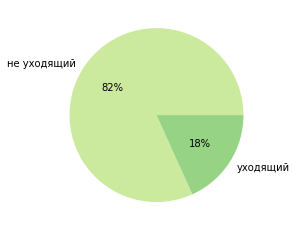

In [54]:
data_groupped = data.groupby(['churn_name'], as_index = False)[['user_id']].count()
plt.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
plt.show()

Уходящих клиентов достаточно много, 18%.

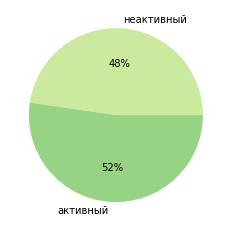

In [55]:
data_groupped = data.groupby(['last_activity'], as_index = False)[['user_id']].count()
# plt.pie(data_groupped['user_id'], labels = data_groupped['last_activity'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
labels = data_groupped['last_activity'].apply(lambda x: 'активный' if x == 1 else 'неактивный')
plt.pie(data_groupped['user_id'], labels = labels, colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
plt.show()

Активных и неактивных клиентов примерно поровну.

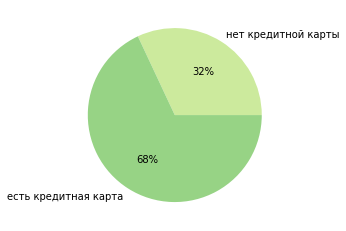

In [56]:
data_groupped = data.groupby(['credit_card'], as_index = False)[['user_id']].count()
# plt.pie(data_groupped['user_id'], labels = data_groupped['credit_card'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
labels = data_groupped['credit_card'].apply(lambda x: 'есть кредитная карта' if x == 1 else 'нет кредитной карты')
plt.pie(data_groupped['user_id'], labels = labels, colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
plt.show()

Большинство клиентов имеют кредитную карту.

###### Анализ по количеству продуктов

In [57]:
# уходящие и не уходящие клиенты по имеющемуся количеству продуктов
data_groupped = data.groupby(['products', 'churn_name'], \
                        as_index = False)[['user_id']].count()
data_groupped

,products,churn_name,user_id
0,1,не уходящий,3088
1,1,уходящий,235
2,2,не уходящий,4141
3,2,уходящий,978
4,3,не уходящий,741
5,3,уходящий,297
6,4,не уходящий,174
7,4,уходящий,300
8,5,не уходящий,11
9,5,уходящий,8


~~Клиентов с 5 продуктами совсем мало, по этой категории (клиенты с 5 продуктами) нельзя будет сделать корректные выводы, построим графики без них.~~

No handles with labels found to put in legend.


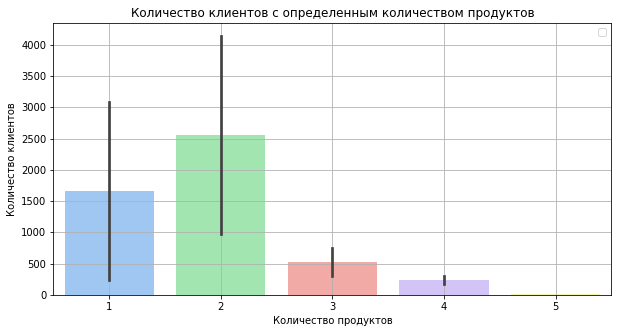

In [58]:
# назначаем размер графика
plt.figure(figsize=(10, 5))
# строим столбчатый график средствами seaborn
# sns.barplot(x='products', y='user_id', data=data_groupped[data_groupped['products'] != 5])
sns.barplot(x='products', y='user_id', data=data_groupped)
plt.title('Количество клиентов с определенным количеством продуктов')
plt.xlabel('Количество продуктов')
plt.ylabel('Количество клиентов')
plt.legend(loc='upper right', fontsize=10)
plt.grid()
plt.show()

Больше всего клиентов с 2 продуктами - около 2500, также с 1 - около 1600. <br><br>
Клиентов с 5 продуктами очень мало, их даже не видно на графике.<br><br>

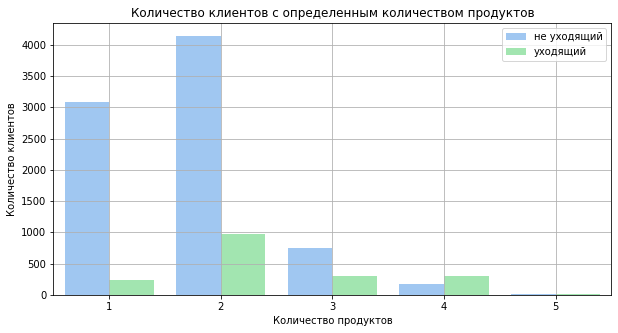

In [59]:
# назначаем размер графика
plt.figure(figsize=(10, 5))
# строим столбчатый график средствами seaborn
# sns.barplot(x='products', y='user_id', data=data_groupped[data_groupped['products'] != 5], hue='churn_name')
sns.barplot(x='products', y='user_id', data=data_groupped, hue='churn_name')
plt.title('Количество клиентов с определенным количеством продуктов')
plt.xlabel('Количество продуктов')
plt.ylabel('Количество клиентов')
plt.legend(loc='upper right', fontsize=10)
plt.grid()
plt.show()

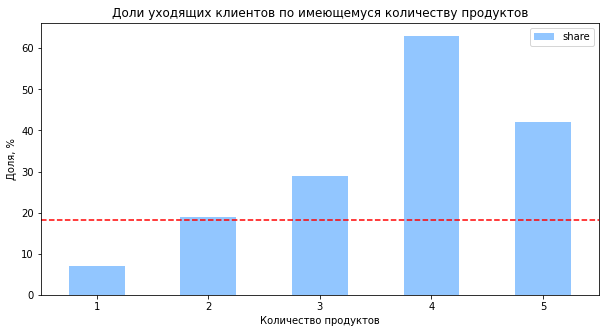

In [60]:
# data_share = data[data['products'] != 5].pivot_table(index='products', columns='churn', values='user_id', aggfunc='count')
data_share = data.pivot_table(index='products', columns='churn', values='user_id', aggfunc='count')

data_share.columns = ['not_churn', 'churn']
data_share['total'] = data_share['not_churn'] + data_share['churn']
data_share['share'] = (data_share['churn']/data_share['total']*100).round().astype('int')

# доли уходящих клиентов
data_share = data_share.sort_values(by='products', ascending=True)
data_share.plot(y='share', kind='bar', figsize=(10, 5));
plt.axhline(y=churn_val*100, color='red', linestyle='--', label='Уровень')
plt.title('Доли уходящих клиентов по имеющемуся количеству продуктов')
plt.xlabel('Количество продуктов')
plt.ylabel('Доля, %')
plt.xticks(rotation=0)
plt.show()

У клиентов с 1 продуктом процент уходящих меньше среднего процента по банку, у клиентов с 2 продуктами совпадает со средним процентом по банку.<br>
У клиентов с 3, 4 и 5 продуктами процент уходящих превышает средний процент по банку.<br>
У клиентов с 4 продуктами доля уходящих превышает долю не уходящих.

###### Анализ по количеству баллов собственности

In [61]:
# уходящие и не уходящие клиенты по количеству баллов собственности
data_groupped = data.groupby(['equity', 'churn_name'], \
                        as_index = False)[['user_id']].count()
data_groupped

,equity,churn_name,user_id
0,0,не уходящий,2486
1,0,уходящий,90
2,1,не уходящий,680
3,1,уходящий,93
4,2,не уходящий,885
5,2,уходящий,166
6,3,не уходящий,1219
7,3,уходящий,321
8,4,не уходящий,1383
9,4,уходящий,464


No handles with labels found to put in legend.


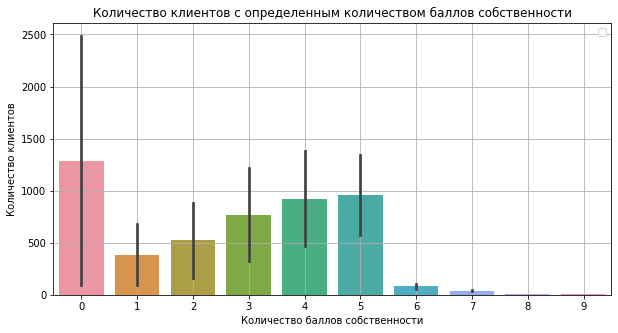

In [62]:
# назначаем размер графика
plt.figure(figsize=(10, 5))
# строим столбчатый график средствами seaborn
# sns.barplot(x='equity', y='user_id', data=data_groupped[~data_groupped['equity'].isin([8, 9])])
sns.barplot(x='equity', y='user_id', data=data_groupped)
plt.title('Количество клиентов с определенным количеством баллов собственности')
plt.xlabel('Количество баллов собственности')
plt.ylabel('Количество клиентов')
plt.legend(loc='upper right', fontsize=10)
plt.grid()
plt.show()

Больше всего клиентов с 0 баллами собственности, но также много клиентов и с другими баллами, кроме клиентов, у которых от 6 баллов.

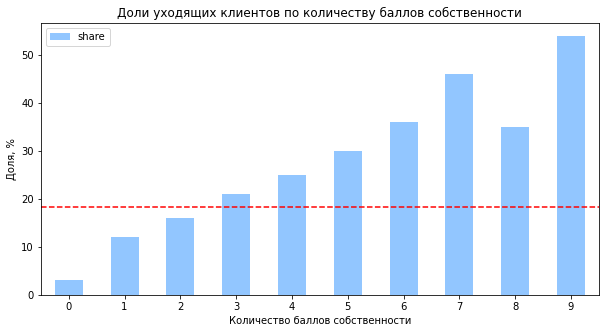

In [63]:
data_share = data.pivot_table(index='equity', columns='churn', values='user_id', aggfunc='count')
data_share.columns = ['not_churn', 'churn']
data_share['total'] = data_share['not_churn'] + data_share['churn']
data_share['share'] = (data_share['churn']/data_share['total']*100).round().astype('int')

# доли уходящих клиентов
data_share = data_share.sort_values(by='equity', ascending=True)
data_share.plot(y='share', kind='bar', figsize=(10, 5));
plt.axhline(y=churn_val*100, color='red', linestyle='--', label='Уровень')
plt.title('Доли уходящих клиентов по количеству баллов собственности')
plt.xlabel('Количество баллов собственности')
plt.ylabel('Доля, %')
plt.xticks(rotation=0)
plt.show()

Чем больше баллов собственности, тем выше процент уходящих клиентов.

У клиентов с 0, 1 и 2 баллами собственности процент уходящих клиентов меньше среднего процента уходящих по банку, у других клиентов больше.

###### Анализ по городам

No handles with labels found to put in legend.


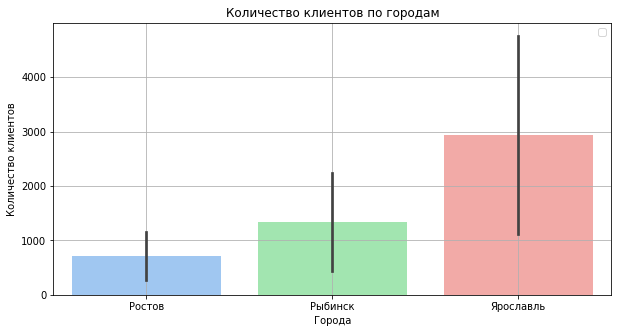

In [64]:
data_groupped = data.groupby(['city', 'churn_name'], \
                        as_index = False)[['user_id']].count()
# назначаем размер графика
plt.figure(figsize=(10, 5))
# строим столбчатый график средствами seaborn
sns.barplot(x='city', y='user_id', data=data_groupped)
plt.title('Количество клиентов по городам')
plt.xlabel('Города')
plt.ylabel('Количество клиентов')
plt.legend(loc='upper right', fontsize=10)
plt.grid()
plt.show()

Больше всего клиентов в Ярославле, что логично, этот город крупнее.

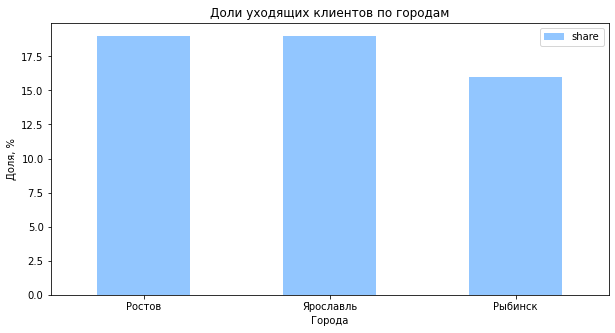

In [65]:
data_share = data.pivot_table(index='city', columns='churn', values='user_id', aggfunc='count')
data_share.columns = ['not_churn', 'churn']
data_share['total'] = data_share['not_churn'] + data_share['churn']
data_share['share'] = (data_share['churn']/data_share['total']*100).round().astype('int')
data_share.sort_values(by='share', ascending=False)

# доли уходящих клиентов
data_share = data_share.sort_values(by='share', ascending=False)
data_share.plot(y='share', kind='bar', figsize=(10, 5));
plt.title('Доли уходящих клиентов по городам')
plt.xlabel('Города')
plt.ylabel('Доля, %')
plt.xticks(rotation=0)
plt.show()

Доля уходящих клиентов почти не отличается по городам.

###### Анализ по возрасту, кредитному рейтингу, балансу

Возраст:

Text(0, 0.5, 'Количество клиентов, %')

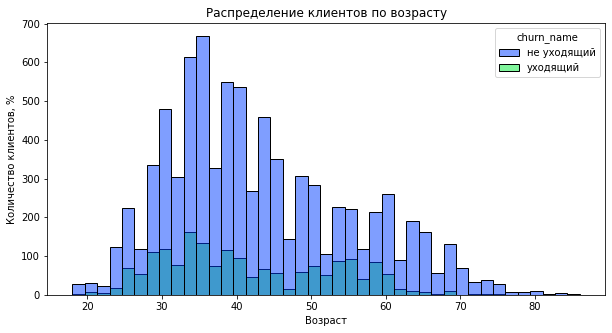

In [66]:
# гистограмма по возрасту в разрезе уходящих/не уходящих
plt.figure(figsize=(10, 5))
with plt.style.context('seaborn-bright'):
    sns.histplot(data=data, x="age", hue="churn_name", hue_order=["не уходящий", "уходящий"]) 
plt.title('Распределение клиентов по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Количество клиентов, %')

Text(0, 0.5, 'Доля, %')

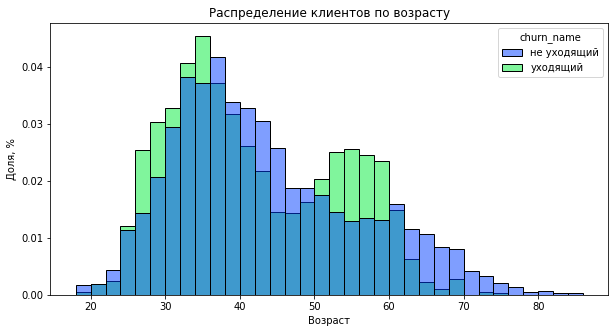

In [67]:
# гистограмма по возрасту в разрезе уходящих/не уходящих
plt.figure(figsize=(10, 5))
with plt.style.context('seaborn-bright'):
    sns.histplot(data=data, x="age", hue="churn_name", hue_order=["не уходящий", "уходящий"], stat="density", common_norm=False, binwidth=2) 
plt.title('Распределение клиентов по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Доля, %')

Клиенты в возрасте примерно от 50 до 60 процент уходящих клиентов выше. Также есть уходящие среди клиентов в возрасте от 26 до до 36 лет.

Кредитный рейтинг:

Text(0, 0.5, 'Количество')

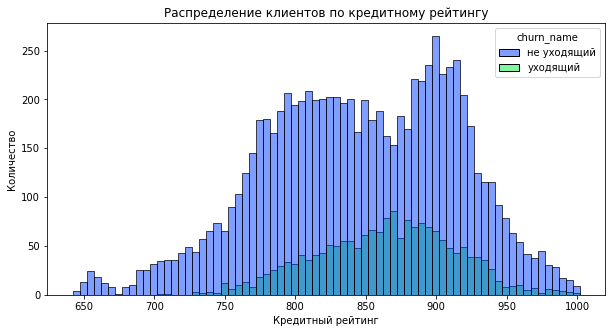

In [68]:
# гистограмма по кредитному рейтингу в разрезе уходящих/не уходящих
plt.figure(figsize=(10, 5))
with plt.style.context('seaborn-bright'):
    sns.histplot(data=data, x="score", hue="churn_name", hue_order=["не уходящий", "уходящий"], binwidth=5) 
plt.title('Распределение клиентов по кредитному рейтингу')
plt.xlabel('Кредитный рейтинг')
plt.ylabel('Количество')

Text(0, 0.5, 'Доля, %')

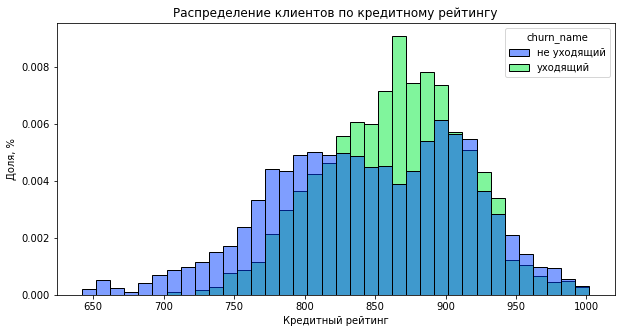

In [69]:
# гистограмма по кредитному рейтингу в разрезе уходящих/не уходящих
plt.figure(figsize=(10, 5))
with plt.style.context('seaborn-bright'):
    sns.histplot(data=data, x="score", hue="churn_name", hue_order=["не уходящий", "уходящий"], stat="density", common_norm=False, binwidth=10) 
plt.title('Распределение клиентов по кредитному рейтингу')
plt.xlabel('Кредитный рейтинг')
plt.ylabel('Доля, %')

Клиенты с кредитным рейтингом примерно от 820 до 900 процент уходящих клиентов выше, чем с другим рейтингом.

Доход: 

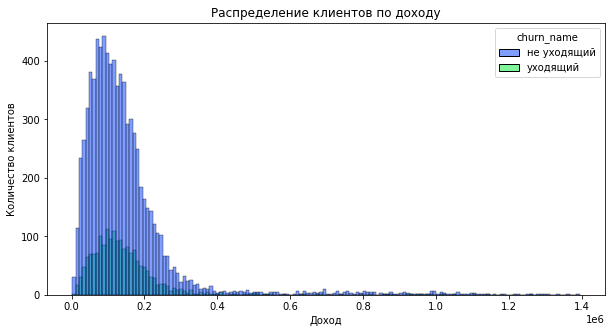

In [70]:
# гистограмма по доходу в разрезе уходящих/не уходящих
plt.figure(figsize=(10, 5))
with plt.style.context('seaborn-bright'):
    sns.histplot(data=data, x="est_salary", hue="churn_name", hue_order=["не уходящий", "уходящий"]) 
plt.title('Распределение клиентов по доходу')
plt.xlabel('Доход')
plt.ylabel('Количество клиентов')
plt.show()

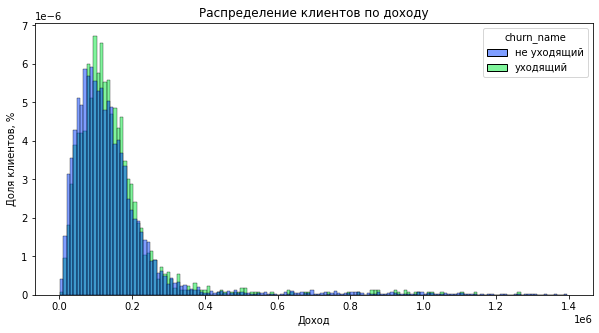

In [71]:
# гистограмма по доходу в разрезе уходящих/не уходящих
plt.figure(figsize=(10, 5))
with plt.style.context('seaborn-bright'):
    sns.histplot(data=data, x="est_salary", hue="churn_name", hue_order=["не уходящий", "уходящий"], stat="density", common_norm=False) 
plt.title('Распределение клиентов по доходу')
plt.xlabel('Доход')
plt.ylabel('Доля клиентов, %')
plt.show()  

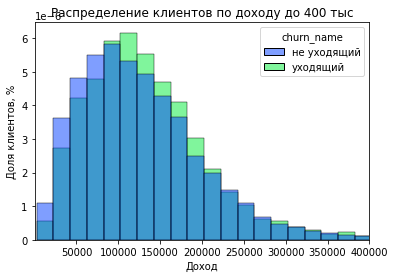

In [72]:
# гистограмма по доходу до 400 тыс в разрезе уходящих/не уходящих
fig, ax = plt.subplots()
# plt.figure(figsize=(10, 5))
with plt.style.context('seaborn-bright'):
    sns.histplot(data=data, x="est_salary", hue="churn_name", hue_order=["не уходящий", "уходящий"], stat="density", common_norm=False, ax=ax, binwidth=20000)
ax.set_xlim(1,400000) 
ax.set_title('Распределение клиентов по доходу до 400 тыс')
ax.set_xlabel('Доход')
ax.set_ylabel('Доля клиентов, %')
plt.show()

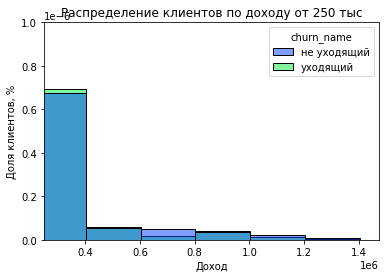

In [73]:
# гистограмма по доходу от 250 тыс в разрезе уходящих/не уходящих
fig, ax = plt.subplots()
# plt.figure(figsize=(10, 5))
with plt.style.context('seaborn-bright'):
    sns.histplot(data=data, x="est_salary", hue="churn_name", hue_order=["не уходящий", "уходящий"], stat="density", common_norm=False, ax=ax, binwidth=200000)
ax.set_xlim(250000, )    
ax.set_ylim(0, 0.000001)
ax.set_title('Распределение клиентов по доходу от 250 тыс')
ax.set_xlabel('Доход')
ax.set_ylabel('Доля клиентов, %')
plt.show()

Большой процент уходящих среди клиентов с доходом от 100 до 200 тыс

Баланс:

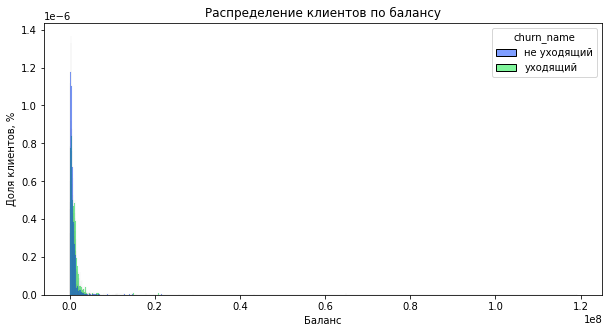

In [74]:
# гистограмма по балансу в разрезе уходящих/не уходящих
plt.figure(figsize=(10, 5))
with plt.style.context('seaborn-bright'):
    sns.histplot(data=data, x="balance", hue="churn_name", hue_order=["не уходящий", "уходящий"], stat="density", common_norm=False)
plt.title('Распределение клиентов по балансу')
plt.xlabel('Баланс')
plt.ylabel('Доля клиентов, %')

plt.show()   

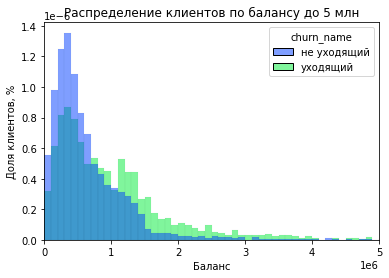

In [75]:
# гистограмма по балансу от 500 тыс до 2 млн в разрезе уходящих/не уходящих
fig, ax = plt.subplots()
with plt.style.context('seaborn-bright'):
    sns.histplot(data=data, x="balance", hue="churn_name", hue_order=["не уходящий", "уходящий"], stat="density", common_norm=False, ax=ax, binwidth=100000)
ax.set_xlim(0, 5000000)
# ax.set_ylim(0, 0.000001)
# plt.figure(figsize=(15, 5))
ax.set_title('Распределение клиентов по балансу до 5 млн')
ax.set_xlabel('Баланс')
ax.set_ylabel('Доля клиентов, %')
plt.show()

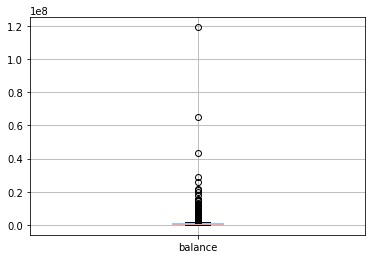

In [76]:
data[['balance']].boxplot();

(0.0, 10000000.0)

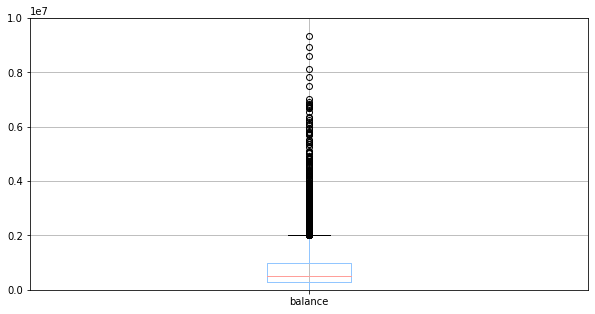

In [77]:
data.boxplot(column='balance', figsize=(10, 5));
plt.ylim(0,10000000)

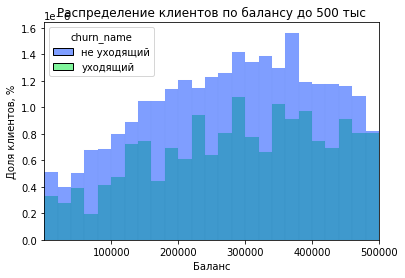

<Figure size 720x360 with 0 Axes>

In [78]:
# гистограмма по балансу до 500 тыс в разрезе уходящих/не уходящих
fig, ax = plt.subplots()
# plt.figure(figsize=(10, 5))
with plt.style.context('seaborn-bright'):
    sns.histplot(data=data, x="balance", hue="churn_name", hue_order=["не уходящий", "уходящий"], stat="density", common_norm=False, ax=ax, binwidth=20000)
    plt.figure(figsize=(10, 5))
ax.set_xlim(1, 500000) 
ax.set_title('Распределение клиентов по балансу до 500 тыс')
ax.set_xlabel('Баланс')
ax.set_ylabel('Доля клиентов, %')
plt.show()

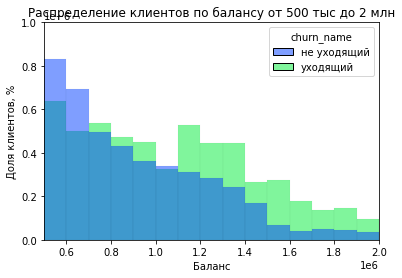

In [79]:
# гистограмма по балансу от 500 тыс до 2 млн в разрезе уходящих/не уходящих
fig, ax = plt.subplots()
with plt.style.context('seaborn-bright'):
    sns.histplot(data=data, x="balance", hue="churn_name", hue_order=["не уходящий", "уходящий"], stat="density", common_norm=False, ax=ax, binwidth=100000)
ax.set_xlim(500000, 2000000)
ax.set_ylim(0, 0.000001)
# plt.figure(figsize=(15, 5))
ax.set_title('Распределение клиентов по балансу от 500 тыс до 2 млн')
ax.set_xlabel('Баланс')
ax.set_ylabel('Доля клиентов, %')
plt.show()

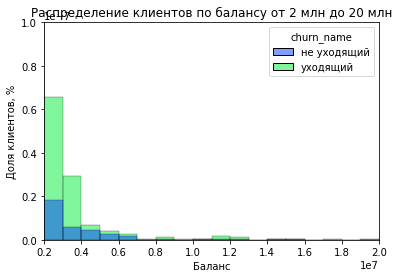

In [80]:
# гистограмма по балансу от 2 млн до 20 млн в разрезе уходящих/не уходящих
# plt.figure(figsize=(10, 5))
fig, ax = plt.subplots()
with plt.style.context('seaborn-bright'):
    sns.histplot(data=data, x="balance", hue="churn_name", hue_order=["не уходящий", "уходящий"], stat="density", common_norm=False, ax=ax, binwidth=1000000)
ax.set_xlim(2000000, 20000000)
ax.set_ylim(0, 0.0000001)
ax.set_title('Распределение клиентов по балансу от 2 млн до 20 млн')
ax.set_xlabel('Баланс')
ax.set_ylabel('Доля клиентов, %')
plt.show()

Много уходящих клиентов с балансом от 900 тыс.

###### Анализ по наличию кредитной карты, полу, признаку активности

Наличие/отсутствие кредитной карты:

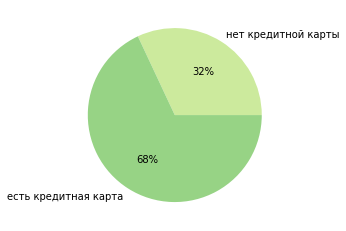

In [81]:
data_groupped = data.groupby(['credit_card'], as_index = False)[['user_id']].count()
labels = data_groupped['credit_card'].apply(lambda x: 'есть кредитная карта' if x == 1 else 'нет кредитной карты')
plt.pie(data_groupped['user_id'], labels = labels, colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
plt.show()

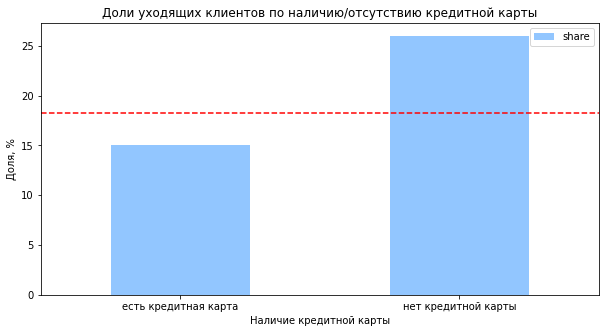

In [82]:
data_share = data.pivot_table(index='credit_card', columns='churn', values='user_id', aggfunc='count')
data_share = data_share.sort_values(by='credit_card')
data_share.index = pd.Index(['нет кредитной карты', 'есть кредитная карта'], name='credit_card')

data_share.columns = ['not_churn', 'churn']
data_share['total'] = data_share['not_churn'] + data_share['churn']
data_share['share'] = (data_share['churn']/data_share['total']*100).round().astype('int')

# доли уходящих клиентов
data_share = data_share.sort_values(by='share', ascending=True)
data_share.plot(y='share', kind='bar', figsize=(10, 5));
plt.axhline(y=churn_val*100, color='red', linestyle='--', label='Уровень')
plt.title('Доли уходящих клиентов по наличию/отсутствию кредитной карты')
plt.xlabel('Наличие кредитной карты')
plt.ylabel('Доля, %')
plt.xticks(rotation=0)
plt.show()

Процент уходящих среди клиентов без кредитной карты выше, чем среди клиентов с кредитной.

Пол клиентов:

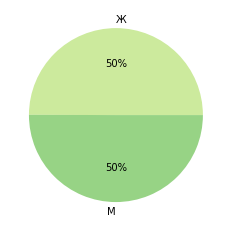

In [83]:
data_groupped = data.groupby(['gender'], as_index = False)[['user_id']].count()
plt.pie(data_groupped['user_id'], labels = data_groupped['gender'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
plt.show()

Среди клиентов банка одинаковое количество мужчин и женщин.

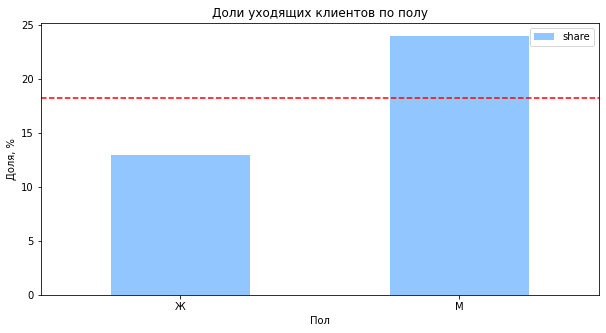

In [84]:
data_share = data.pivot_table(index='gender', columns='churn', values='user_id', aggfunc='count')

data_share.columns = ['not_churn', 'churn']
data_share['total'] = data_share['not_churn'] + data_share['churn']
data_share['share'] = (data_share['churn']/data_share['total']*100).round().astype('int')
data_share.sort_values(by='share', ascending=True)

# доли уходящих клиентов
data_share = data_share.sort_values(by='share', ascending=True)
data_share.plot(y='share', kind='bar', figsize=(10, 5));
plt.axhline(y=churn_val*100, color='red', linestyle='--', label='Уровень')
plt.title('Доли уходящих клиентов по полу')
plt.xlabel('Пол')
plt.ylabel('Доля, %')
plt.xticks(rotation=0)
plt.show()

Процент уходящих клиентов среди мужчин выше, чем среди женщин.

Признак активности:

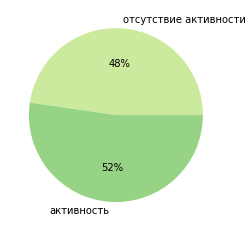

In [85]:
data_groupped = data.groupby(['last_activity'], as_index = False)[['user_id']].count()
labels = data_groupped['last_activity'].apply(lambda x: 'активность' if x == 1 else 'отсутствие активности')
plt.pie(data_groupped['user_id'], labels = labels, colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
plt.show()

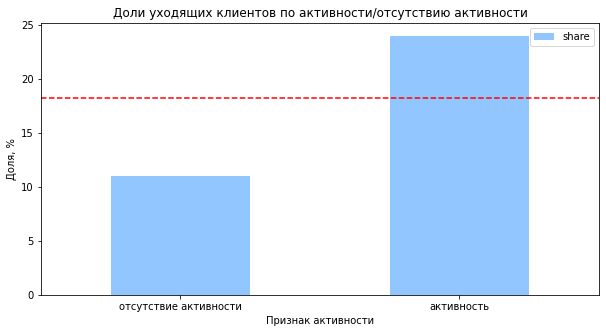

In [86]:
data_share = data.pivot_table(index='last_activity', columns='churn', values='user_id', aggfunc='count')
data_share = data_share.sort_values(by='last_activity')
data_share.index = pd.Index(['отсутствие активности', 'активность'], name='credit_card')

data_share.columns = ['not_churn', 'churn']
data_share['total'] = data_share['not_churn'] + data_share['churn']
data_share['share'] = (data_share['churn']/data_share['total']*100).round().astype('int')

# доли уходящих клиентов
data_share = data_share.sort_values(by='share', ascending=True)
data_share.plot(y='share', kind='bar', figsize=(10, 5));
plt.axhline(y=churn_val*100, color='red', linestyle='--', label='Уровень')
plt.title('Доли уходящих клиентов по активности/отсутствию активности')
plt.xlabel('Признак активности')
plt.ylabel('Доля, %')
plt.xticks(rotation=0)
plt.show()

Процент уходящих клиентов среди клиентов с недавней активностью выше, чем среди клиентов без недавней активности. Возможно, уходящих клиенты закрывают вклады или кредиты, поэтому у них признак недавней активности.

###### Выводы и наблюдения<br>

- Чем больше продуктов у клиентов, тем выше процент уходящих клиентов<br>
- Чем больше баллов собственности, тем выше процент уходящих клиентов<br>
- Клиенты в возрасте примерно от 26 до 36 и от 50 до 60 - процент уходящих клиентов выше<br>
- Среди клиентов с кредитным рейтингом примерно от 820 до 910 процент уходящих клиентов выше<br>
- Много уходящих клиентов с балансом от 900 тыс<br>
- Процент уходящих среди клиентов без кредитной карты выше, чем среди клиентов с кредитной
- Процент уходящих клиентов среди мужчин выше, чем среди женщин
- Процент уходящих клиентов среди клиентов с недавней активностью выше, чем среди клиентов без недавней активности
    
    
Неуходящие клиенты:<br>

- с небольшим количеством баллов собственности
- с небольшим количеством продуктов
- с кредитной картой

##### Анализ по таблице признаков

In [87]:
# преобразование данных в датафрейм (для данных, сгруппированных по признаку)
def get_measures_df(measures):
    measures = pd.DataFrame(measures, columns=['attr', 'median_0', 'median_1', 'mean_0', 'mean_1', 'count_0',  'count_1'])
    # разница в среднем значении
    measures['diff'] = measures.apply(lambda x: max(x['mean_0'], x['mean_1']) / min(x['mean_0'], x['mean_1']) \
                                      if min(x['mean_0'], x['mean_1']) != 0 else None, axis=1)
    # значение признака, у которого значение среднего больше 
    measures['attr_value'] = measures.apply(lambda x: 0 if max(x['mean_0'], x['mean_1']) == x['mean_0'] else 1, axis=1)
    
    return measures.sort_values(by='diff', ascending = False)

# преобразование данных в датафрейм (для данных, сгруппированных по признаку оттока)
def get_measures_df_churn(measures):
    measures = pd.DataFrame(measures, columns=['attr', 'median_0', 'median_1', 'mean_0', 'mean_1'])
    # разница в любую сторону
    measures['diff'] = measures.apply(lambda x: max(x['mean_0'], x['mean_1']) / min(x['mean_0'], x['mean_1']) \
                                      if min(x['mean_0'], x['mean_1']) != 0 else None, axis=1)
    # разница: отношение значения уходящих к значению неуходящих
    measures['diff_churn'] = measures.apply(lambda x: x['mean_1'] / x['mean_0'] if x['mean_0'] != 0 else None, axis=1)

    return measures.sort_values(by='diff_churn', ascending = False)

In [88]:
# список признаков 
attr_list = data.columns.values.tolist()
for i in ['user_id', 'gender', 'churn', 'null_balance', 'null_age', 'city', 'products',  'equity', 'churn_name']:
    attr_list.remove(i)
attr_list
#'products_5','equity_8', 'equity_9', 

['score',
 'age',
 'balance',
 'credit_card',
 'last_activity',
 'est_salary',
 'gender_num',
 'city_Ростов',
 'city_Рыбинск',
 'city_Ярославль',
 'products_1',
 'products_2',
 'products_3',
 'products_4',
 'products_5',
 'equity_0',
 'equity_1',
 'equity_2',
 'equity_3',
 'equity_4',
 'equity_5',
 'equity_6',
 'equity_7',
 'equity_8',
 'equity_9']

In [89]:
# расчет мер центр. тендеции при группировке по признакам
measures = get_central_tendency_measures(data, ['churn'], attr_list, ['median', 'mean', 'count'])
measures = get_measures_df(measures)
measures

,attr,median_0,median_1,mean_0,mean_1,count_0,count_1,diff,attr_value
15,equity_0,0.0,0.0,0.233608,0.034938,7397.0,2576.0,6.686386,0
13,products_4,0.0,1.0,0.159806,0.632911,9499.0,474.0,3.960491,1
10,products_1,0.0,0.0,0.238045,0.070719,6650.0,3323.0,3.366059,0
24,equity_9,0.0,1.0,0.181827,0.538462,9960.0,13.0,2.961390,1
22,equity_7,0.0,0.0,0.180026,0.462500,9893.0,80.0,2.569069,1
14,products_5,0.0,0.0,0.181836,0.421053,9954.0,19.0,2.315557,1
4,last_activity,0.0,0.0,0.113703,0.244871,4758.0,5215.0,2.153594,1
21,equity_6,0.0,0.0,0.179372,0.360248,9812.0,161.0,2.008385,1
20,equity_5,0.0,0.0,0.154133,0.300783,8058.0,1915.0,1.951459,1
23,equity_8,0.0,0.0,0.182001,0.352941,9956.0,17.0,1.939229,1


Обнаружены разницы по среднему значению по следующим признакам между уходящими и неуходящими клиентами:
- заметна тенденция, что если у клиентов много продуктов или баллов собственности, то больше уходящих клиентов
- у уходящих клиентов с 4 и 3 продуктам разница с неуходящими в 4 и 1.7 раза соответственно
- у уходящих клиентов активность выше в 2.2 раза
- у уходящих клиентов больше доля мужчин - 1.9 раз
- у уходящих клиентов больше тех, у кого кредитная карта (но и в целом в банке больше тех клиентов, у кого она есть)


- у неуходящих клиентов с 1 продуктом разница с неуходящими в 3.4 раза 
- у неуходящих клиентов с баллами собственности 0 и 1 разница с неуходящими в 6.7 и 1.6 раза

Проверим с отбором по признакам, по которым есть разница. Также проверим по тем признакам, по которым была найдена разница в пункте "Анализ признаков"

In [90]:
# расчет мер центр. тендеции при группировке по полю churn по значениям непрерывным и с большим количеством значений
measures = get_central_tendency_measures_churn(data, ['churn'], ['score', 'balance', 'est_salary', 'age'], ['median', 'mean'])
measures = get_measures_df_churn(measures)
measures

,attr,median_0,median_1,mean_0,mean_1,diff,diff_churn
1,balance,475410.09,783908.90,733031.630149,1.134458e+06,1.547625,1.547625
0,score,848.00,866.00,845.396199,8.633619e+02,1.021251,1.021251
2,est_salary,118227.60,125408.88,147674.637881,1.483575e+05,1.004624,1.004624
3,age,40.00,39.00,43.020846,4.142959e+01,1.038409,0.963012


При группировке по признаку ухода: у уходящих клиентов разница с неуходящими по среднему балансу в 1.5 раза (но тут может быть просто связь между тем, что у кого много собственности, то и баланс больше)

##### Корреляция всех признаков таблицы

In [91]:
data_corr.head()

,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,850,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1
1,861,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0
2,892,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0
3,866,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1
4,730,Ярославль,М,34,5,174.00,1,1,0,67353.16,1


In [92]:
# корреляция
phik_matrix = data_corr.phik_matrix(interval_cols=['score', 'age', 'est_salary', 'balance'])
phik_matrix = phik_matrix.round(3)
phik_matrix

,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
score,1.000,0.091,0.071,0.034,0.527,0.171,0.420,0.208,0.052,0.395,0.230
city,0.091,1.000,0.012,0.091,0.063,0.040,0.125,0.075,0.031,0.171,0.017
gender,0.071,0.012,1.000,0.286,0.064,0.045,0.072,0.196,0.013,0.144,0.220
age,0.034,0.091,0.286,1.000,0.046,0.019,0.141,0.157,0.090,0.360,0.193
equity,0.527,0.063,0.064,0.046,1.000,0.000,0.583,0.221,0.051,0.286,0.352
balance,0.171,0.040,0.045,0.019,0.000,1.000,0.000,0.000,0.000,0.374,0.025
products,0.420,0.125,0.072,0.141,0.583,0.000,1.000,0.271,0.113,0.222,0.260
credit_card,0.208,0.075,0.196,0.157,0.221,0.000,0.271,1.000,0.050,0.038,0.202
last_activity,0.052,0.031,0.013,0.090,0.051,0.000,0.113,0.050,1.000,0.045,0.263
est_salary,0.395,0.171,0.144,0.360,0.286,0.374,0.222,0.038,0.045,1.000,0.049


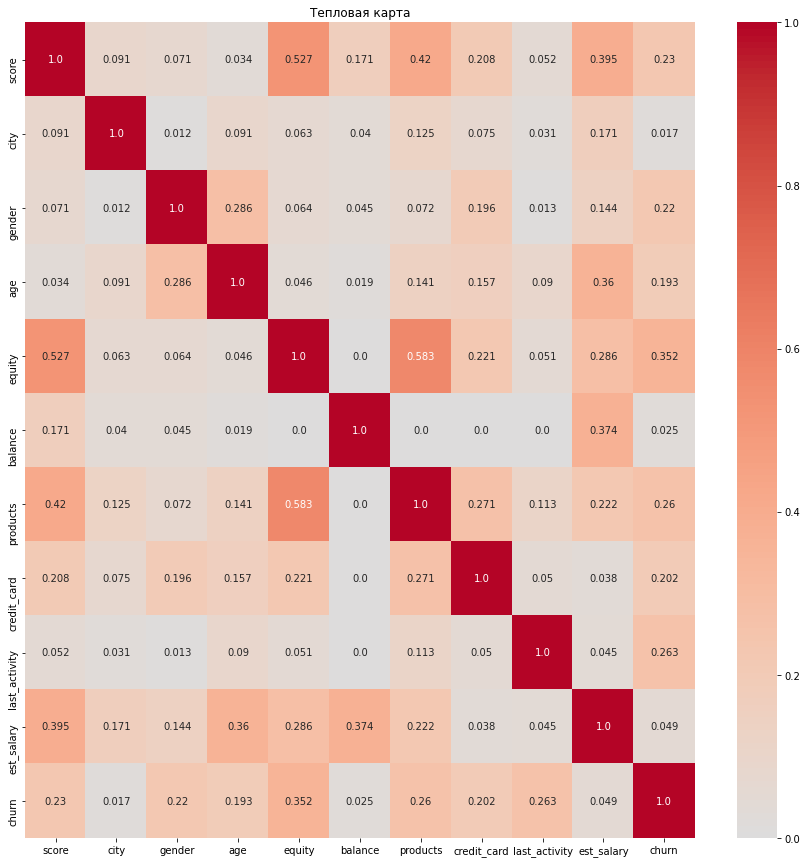

In [93]:
# тепловая карта
plt.figure(figsize=(15, 15)) # задаём размер графика
sns.heatmap(phik_matrix, # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='',
            cmap='coolwarm',
            center=0
           ) # задаём исходный формат
plt.title('Тепловая карта') # название графика
plt.show() 

Обнаружены связи между признаком оттока и следующими признаками:

слабая связь:
- количество баллов собственности (0.35)

очень слабая связь:
- количество продуктов (0.26)
- активность (0.26)
- кредитный рейтинг (0.23)
- пол (0.22)
- наличие кредитной карты (0.2)
- возраст (0.19)

Также обнаружены средние связи между признаками:
- количество баллов собственности и кредитный рейтинг
- количество баллов собственности и количество продуктов

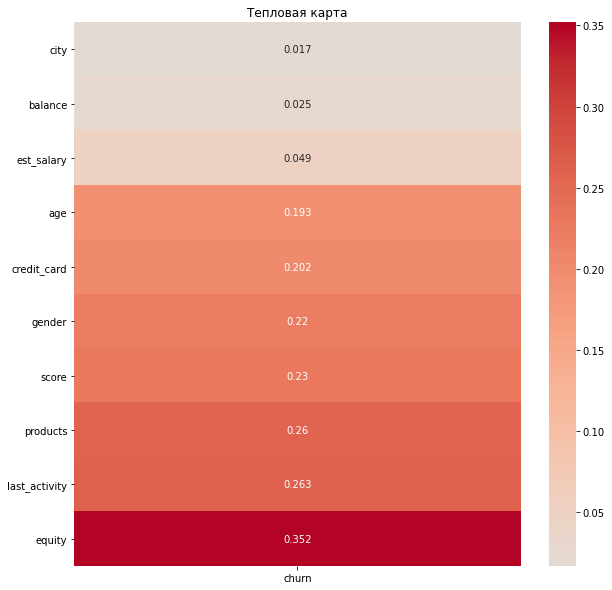

In [94]:
# тепловая карта
plt.figure(figsize=(10, 10)) # задаём размер графика
sns.heatmap(phik_matrix.loc[(phik_matrix['churn'] > 0), ['churn']].drop('churn').sort_values('churn'), # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='',
            cmap='coolwarm',
            center=0
           ) # задаём исходный формат
plt.title('Тепловая карта') # название графика
plt.show() 

Дополнительный анализ корреляции:<br>


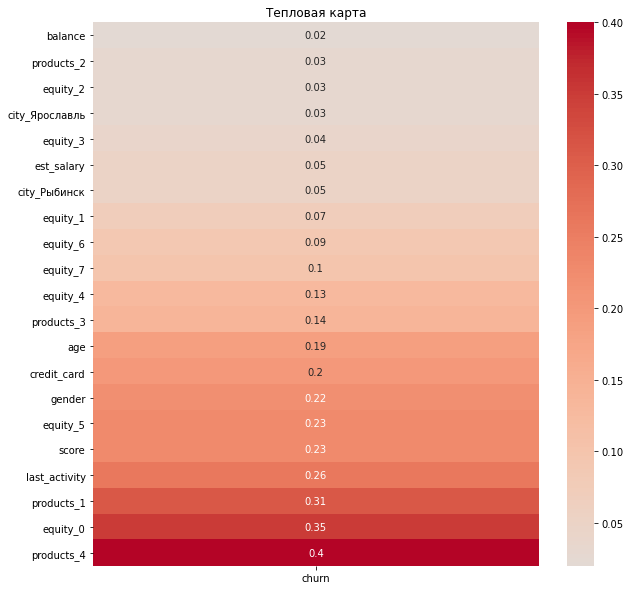

In [95]:
data_corr = data.drop(['user_id', 'churn_name', 'gender_num', 'null_balance', 'null_age', 'city', 'products', 'equity', 'equity_8', 'equity_9', 'products_5'], axis=1)

# корреляция
phik_matrix = data_corr.phik_matrix(interval_cols=['score', 'age', 'est_salary', 'balance'])
phik_matrix = phik_matrix.round(2)

# тепловая карта
plt.figure(figsize=(10, 10)) # задаём размер графика
sns.heatmap(phik_matrix.loc[(phik_matrix['churn'] > 0), ['churn']].drop('churn').sort_values('churn'), # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='',
            cmap='coolwarm',
            center=0
           ) # задаём исходный формат
plt.title('Тепловая карта') # название графика
plt.show() 

Дополнительно обнаружены связи между признаком оттока и следующими признаками:

слабая связь:

- 4 продукта (0.4)
- 0 баллов собственности (0.35) - по ранее проведенному анализу можно сделать вывод, что это обратная связь, у кого не 0 баллов 
- 1 продукт (0.31) - по ранее проведенному анализу можно сделать вывод, что это обратная связь, у кого не 1 продукт 


/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable products_1 for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable products_2 for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable products_3 for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable products_4 for analysis 1. Dropping this column
  warnings.warn(


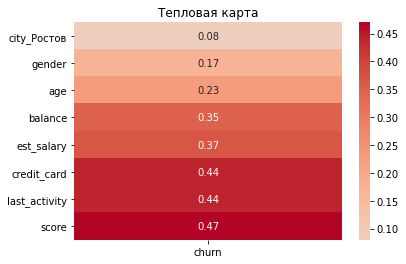

In [96]:
# корреляция
phik_matrix = data_corr[data_corr['products_4'] == 1].phik_matrix(interval_cols=['score', 'age', 'est_salary', 'balance'])
phik_matrix = phik_matrix.round(2)

# тепловая карта
sns.heatmap(phik_matrix.loc[(phik_matrix['churn'] > 0), ['churn']].drop('churn').sort_values('churn'), # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='',
            cmap='coolwarm',
            center=0
           ) # задаём исходный формат
plt.title('Тепловая карта') # название графика
plt.show() 

Есть также корреляция оттока 0.47 с кредитным рейтингом по тем клиентам, у кого 4 продукта.

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable last_activity for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable products_1 for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable products_2 for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable products_3 for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable products_4 for analysis 1. Dropping this column
  warnings.warn(


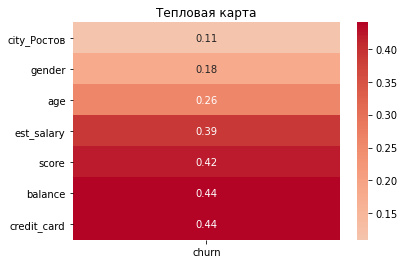

In [97]:
# корреляция
phik_matrix = data_corr[(data_corr['products_4'] == 1) & (data_corr['last_activity'] == 1)].phik_matrix(interval_cols=['score', 'age', 'est_salary', 'balance'])
phik_matrix = phik_matrix.round(2)

# тепловая карта
sns.heatmap(phik_matrix.loc[(phik_matrix['churn'] > 0), ['churn']].drop('churn').sort_values('churn'), # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='',
            cmap='coolwarm',
            center=0
           ) # задаём исходный формат
plt.title('Тепловая карта') # название графика
plt.show() 

Есть также корреляция оттока 0.44 с признаком кредитной карты по тем клиентам, у кого 4 продукта и признак активности.

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable last_activity for analysis 1. Dropping this column
  warnings.warn(


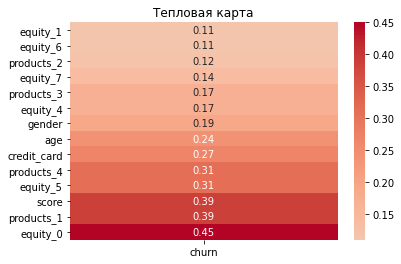

In [98]:
# корреляция
phik_matrix = data_corr[(data_corr['last_activity'] == 1)].phik_matrix(interval_cols=['score', 'age', 'est_salary', 'balance'])
phik_matrix = phik_matrix.round(2)

# тепловая карта
sns.heatmap(phik_matrix.loc[(phik_matrix['churn'] > 0.1), ['churn']].drop('churn').sort_values('churn'), # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='',
            cmap='coolwarm',
            center=0
           ) # задаём исходный формат
plt.title('Тепловая карта') # название графика
plt.show() 

Есть также корреляция оттока 0.45 с признаком 0 баллов собственности (отсутствие 0 баллов) по тем клиентам, у кого признак активности.

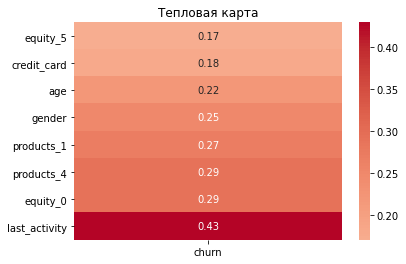

In [99]:
# корреляция
phik_matrix = data_corr[(data['score'] >= 820) & (data['score'] <= 900)].phik_matrix(interval_cols=['score', 'age', 'est_salary', 'balance'])
phik_matrix = phik_matrix.round(2)

# тепловая карта
sns.heatmap(phik_matrix.loc[(phik_matrix['churn'] > 0.1), ['churn']].drop('churn').sort_values('churn'), # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='',
            cmap='coolwarm',
            center=0
           ) # задаём исходный формат
plt.title('Тепловая карта') # название графика
plt.show() 

Есть также корреляция оттока 0.43 с признаком активности по тем клиентам, у кого кредитный рейтинг от 820 до 900.

###### Выводы

Не обнаружено высококоррелирующих признаков с оттоком. 

#### Проверка статистических гипотез

##### Проверка гипотезы об оттоке и доходах

<b>t-критерий Стьюдента</b><br>

Нулевая гипотеза: средние значения совокупностей доходов уходящих и не уходящих клиентов равны.  
Альтернативная гипотеза: средние значения совокупностей доходов уходящих и не уходящих клиентов отличаются.

Для проведения t-теста нужно проверить три условия:
- генеральные совокупности не зависят друг от друга (условие выполняется, это данные по разным клиенты)
- выборочные средние нормально распределены (условие выполняется, т.к. по ЦПТ выборочные средние распределены нормально, если размер выборки достаточно велик, даже если распределение населения не является нормальным)
- дисперсии рассматриваемых генеральных совокупностей равны (этого не знаем, поэтому параметр equal_var указываем False (т.к. выборки разного размера и, возможно, дисперсии тоже)

In [100]:
# уровень статистической значимости
alpha = 0.05

data_churn = data.loc[data['churn'] == 1]
data_not_churn = data.loc[data['churn'] == 0]

results = st.ttest_ind(data_churn['est_salary'], data_not_churn['est_salary'], equal_var=False, alternative='two-sided')

print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.8354803526840116
Не получилось отвергнуть нулевую гипотезу


<b>Критерий Манна-Уитни</b><br>

In [101]:
results = st.mannwhitneyu(data_churn['est_salary'], data_not_churn['est_salary'], True, 'two-sided')

print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя') 

p-значение:  0.00016830729188229058
Отвергаем нулевую гипотезу: разница статистически значима


Когда в данных есть большие (по сравнению с нормальным распределением) выбросы, алгебраические метрики работают плохо, в таком случае используют непараметрический метод. Поэтому Критерий Манна-Уитни показал другой результат.

##### Проверка гипотезы об оттоке и количестве продуктов

Для определения того, существует ли значительная связь между двумя категориальными переменными используется критерий независимости Хи-квадрат. Используем этот тест для определения связи между количеством продуктов и признаком оттока.

Т.к. 5 продуктов используют мало клиентов, то, чтобы результат был корректным, проверим только для тех клиентов, у которых от 1 до 4 продуктов.

Нулевая гипотеза: признак оттока и количество продуктов (от 1 до 4) независимы  
Альтернативная гипотеза: признак оттока и количество продуктов (от 1 до 4) не являются независимыми  

In [102]:
# группировка по количеству продуктов
data_grouped = data[data['products'] != 5].groupby(['churn'], as_index=False).agg({'products_1':'sum', 'products_2':'sum', 'products_3':'sum', 'products_4':'sum'})
data_grouped = data_grouped.drop(['churn'], axis=1)
data_grouped

,products_1,products_2,products_3,products_4
0,3088.0,4141.0,741.0,174.0
1,235.0,978.0,297.0,300.0


In [103]:
# тест независимости хи-квадрат
results = st.chi2_contingency(data_grouped.values)

print('p-значение:', results[1])
if results[1] < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 4.304088303375159e-217
Отвергаем нулевую гипотезу


Данные дают достаточное основание отвергнуть нулевую гипотезу. Значит, можно сделать вывод, что есть зависимость между количеством продуктов (от 1 до 4 продуктов) и оттоком.

##### Выводы

Проверены гипотезы:
- доходы уходящих и не уходящих клиентов равны (гипотеза отвергнута);
- признак оттока и количество продуктов (от 1 до 4 продуктов) независимы (гипотеза отвергнута)  

Выводы:  
- доходы уходящих и не уходящих клиентов не равны;
- признак оттока и количество продуктов (от 1 до 4) зависимы.

#### Анализ сегментов

###### Анализ с отбором по наличию 4 продуктов

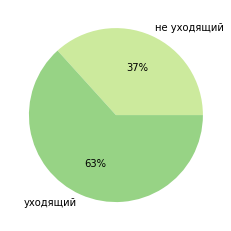

Количество строк: 474


In [104]:
data_part = data[(data['products_4'] == 1)]

data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
plt.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
plt.show()
print('Количество строк:', data_part.shape[0])

In [105]:
# расчет мер центр. тендеции по клиентам при группировке по признакам
measures = get_central_tendency_measures(data[data['products_4'] == 1], ['churn'], attr_list, ['median', 'mean', 'count'])
measures = get_measures_df(measures)
measures

,attr,median_0,median_1,mean_0,mean_1,count_0,count_1,diff,attr_value
3,credit_card,0.0,1.0,0.423841,0.730650,151.0,323.0,1.723878,1
4,last_activity,1.0,1.0,0.910000,0.558824,100.0,374.0,1.628421,0
23,equity_8,1.0,1.0,0.631356,1.000000,472.0,2.0,1.583893,1
24,equity_9,1.0,0.5,0.633475,0.500000,472.0,2.0,1.266949,0
6,gender_num,1.0,1.0,0.558659,0.677966,179.0,295.0,1.213559,1
7,city_Ростов,1.0,1.0,0.647783,0.544118,406.0,68.0,1.190521,0
16,equity_1,1.0,1.0,0.635575,0.538462,461.0,13.0,1.180353,0
18,equity_3,1.0,1.0,0.623762,0.685714,404.0,70.0,1.099320,1
22,equity_7,1.0,1.0,0.631004,0.687500,458.0,16.0,1.089533,1
15,equity_0,1.0,1.0,0.634199,0.583333,462.0,12.0,1.087199,0


У клиентов с 4 продуктами есть разница по среднему значению по признаку наличия кредитной карты и по отсутствию активности.

In [106]:
# расчет мер центр. тендеции по клиентам при группировке по признаку оттока
measures = get_central_tendency_measures_churn(data[data['products_4'] == 1], ['churn'], ['score', 'balance', 'est_salary', 'age'], ['median', 'mean'])
measures = get_measures_df_churn(measures)
measures

,attr,median_0,median_1,mean_0,mean_1,diff,diff_churn
2,est_salary,79326.165,149408.425,105456.282241,1.739219e+05,1.649232,1.649232
1,balance,544353.840,1279267.170,912033.294023,1.474177e+06,1.616363,1.616363
3,age,37.000,39.000,38.114943,4.075000e+01,1.069134,1.069134
0,score,859.000,885.500,869.505747,8.833500e+02,1.015922,1.015922


У клиентов с 4 продуктами при группировке по признаку ухода: у уходящих клиентов разница с неуходящими по среднему значению дохода и балансу в 1.6 раз.

Разница по признаку кредитной карты - 1.7. Кредитная карта также является продуктом, проверим разницу у клиентов с кредитной картой и без:

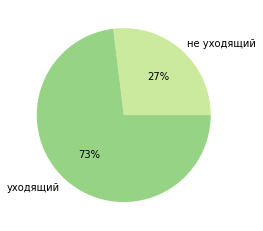

Количество строк: 323


In [107]:
data_part = data[((data['products_4'] == 1)) & (data['credit_card'] == 1) ]

data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
plt.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
plt.show()
print('Количество строк:', data_part.shape[0])

Разница по признаку отсутствия активности - 1.6 раз, проверим с условием тсутствия активности:

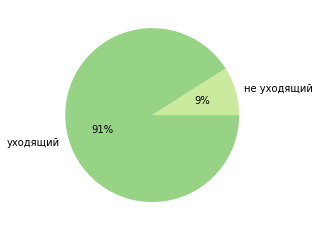

Количество строк: 100


In [108]:
data_part = data[(data['products_4'] == 1) & ((data['last_activity'] == 0))]

data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
plt.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
plt.show()
print('Количество строк:', data_part.shape[0])

Возможно, клиенты, которые пользовались 4 продуктами, попробовали пользоваться подобными продуктами в другом банке и в итоге решили уйти.

Проверим пересечение найденных сегментов:

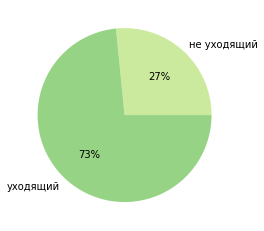

Количество строк: 350


In [109]:
data_part = data[(data['products_4'] == 1) & ((data['credit_card'] == 1) | (data['last_activity'] == 0))]

data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
plt.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
plt.show()
print('Количество строк:', data_part.shape[0])

Сегменты сильно пересекаются - количества 323 и 100, а общее 350.

In [110]:
# расчет мер центр. тендеции по клиентам с кредитной картой при группировке c 4 продуктами
measures = get_central_tendency_measures(data[(data['credit_card'] == 1) & (data['products_4'] == 1)], ['churn'], attr_list, ['median', 'mean', 'count'])
measures = get_measures_df(measures)
measures

,attr,median_0,median_1,mean_0,mean_1,count_0,count_1,diff,attr_value
24,equity_9,1.0,0.5,0.732087,0.500000,321.0,2.0,1.464174,0
4,last_activity,1.0,1.0,0.958904,0.664000,73.0,250.0,1.444133,0
23,equity_8,1.0,1.0,0.729814,1.000000,322.0,1.0,1.370213,1
16,equity_1,1.0,1.0,0.737179,0.545455,312.0,11.0,1.351496,0
7,city_Ростов,1.0,1.0,0.750000,0.604651,280.0,43.0,1.240385,0
21,equity_6,1.0,1.0,0.739274,0.600000,303.0,20.0,1.232123,0
8,city_Рыбинск,1.0,1.0,0.706320,0.851852,269.0,54.0,1.206043,1
18,equity_3,1.0,1.0,0.710145,0.851064,276.0,47.0,1.198437,1
15,equity_0,1.0,1.0,0.733333,0.625000,315.0,8.0,1.173333,0
17,equity_2,1.0,1.0,0.738255,0.640000,298.0,25.0,1.153523,0


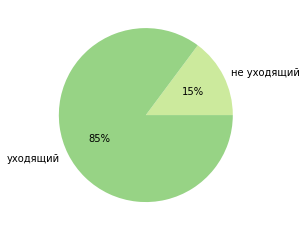

Количество строк: 54


In [111]:
data_part = data[(data['credit_card'] == 1) & ((data['products_4'] == 1)) & ((data['city_Рыбинск'] == 1))]

data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
plt.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
plt.show()

print('Количество строк:', data_part.shape[0])

Слишком маленький сегмент.

(1.0, 5000000.0)

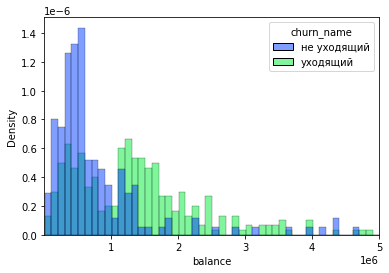

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

In [112]:
# гистограмма по балансу в разрезе уходящих/не уходящих
fig, ax = plt.subplots()
plt.figure(figsize=(10, 5))
with plt.style.context('seaborn-bright'):
    sns.histplot(data=data[(data['products_4'] >= 1)], x="balance", hue="churn_name", hue_order=["не уходящий", "уходящий"], stat="density", common_norm=False, ax=ax, binwidth=100000)
    plt.figure(figsize=(10, 5))
ax.set_xlim(1, 5000000)  

Среди клиентов с 4 продуктами много уходящих с доходом от 1 млн.

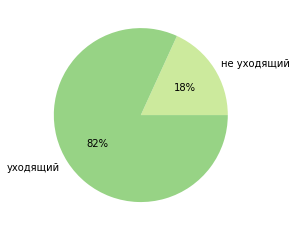

Количество строк: 231


In [113]:
data_part = data[(data['balance'] >= 1000000) & (data['products_4'] >= 1)]

data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
plt.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
plt.show()
print('Количество строк:', data_part.shape[0])

Text(0, 0.5, 'Доля, %')

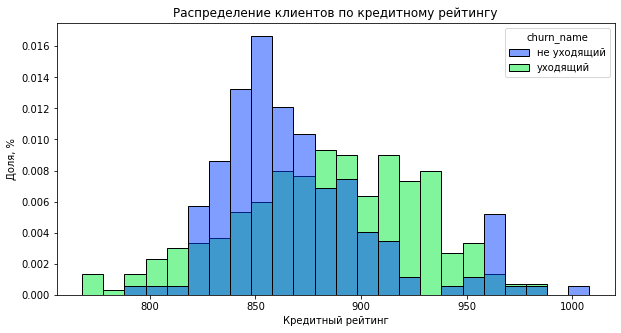

In [114]:
# гистограмма по кредитному рейтингу в разрезе уходящих/не уходящих
plt.figure(figsize=(10, 5))
with plt.style.context('seaborn-bright'):
    sns.histplot(data=data[data['products_4'] == 1], x="score", hue="churn_name", hue_order=["не уходящий", "уходящий"], stat="density", common_norm=False, binwidth=10) 
plt.title('Распределение клиентов по кредитному рейтингу')
plt.xlabel('Кредитный рейтинг')
plt.ylabel('Доля, %')

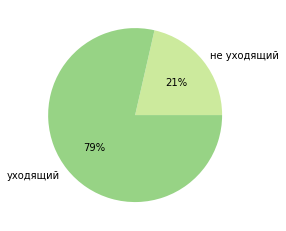

Количество строк: 238


In [115]:
data_part = data[(data['products_4'] == 1) & ((data['score'] <= 820) | ((data['score'] >= 880) & (data['score'] <= 960)))]

data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
plt.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
plt.show()
print('Количество строк:', data_part.shape[0])

Слишком маленький сегмент.

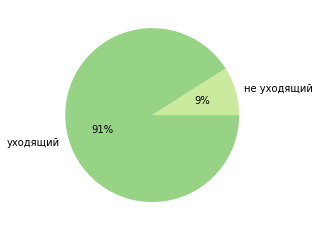

Количество строк: 100


In [116]:
data_part = data[(data['products_4'] == 1) & ((data['last_activity'] == 0))]

data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
plt.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
plt.show()
print('Количество строк:', data_part.shape[0])

Слишком маленький сегмент.

###### Анализ с отбором по наличию 3 продуктов

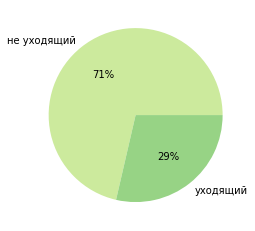

Количество строк: 1038


In [117]:
data_part = data[(data['products_3'] == 1)]

data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
plt.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
plt.show()

print('Количество строк:', data_part.shape[0])

Процент уходящих среди клиентов с 3 продуктами не очень большой, рассмотрим с другими признаками

In [118]:
# расчет мер центр. тендеции по клиентам при группировке по признакам
measures = get_central_tendency_measures(data[data['products_3'] == 1], ['churn'], attr_list, ['median', 'mean', 'count'])
measures = get_measures_df(measures)
measures

,attr,median_0,median_1,mean_0,mean_1,count_0,count_1,diff,attr_value
4,last_activity,0.0,0.0,0.199670,0.407407,606.0,432.0,2.040404,1
15,equity_0,0.0,0.0,0.293878,0.155172,980.0,58.0,1.893878,0
6,gender_num,0.0,0.0,0.213198,0.382550,591.0,447.0,1.794343,1
23,equity_8,0.0,0.5,0.285714,0.500000,1036.0,2.0,1.750000,1
24,equity_9,0.0,0.5,0.285714,0.500000,1036.0,2.0,1.750000,1
20,equity_5,0.0,0.0,0.253298,0.375000,758.0,280.0,1.480469,1
17,equity_2,0.0,0.0,0.296417,0.205128,921.0,117.0,1.445033,0
8,city_Рыбинск,0.0,0.0,0.300115,0.212121,873.0,165.0,1.414826,0
21,equity_6,0.0,0.0,0.283317,0.400000,1013.0,25.0,1.411847,1
22,equity_7,0.0,0.0,0.285019,0.400000,1028.0,10.0,1.403413,1


Есть разница по last_activity в 2 раза и мужскому полу в 1.8 раз.

In [119]:
# расчет мер центр. тендеции по клиентам при группировке по признаку оттока
measures = get_central_tendency_measures_churn(data[data['products_3'] == 1], ['churn'], ['score', 'balance', 'est_salary', 'age'], ['median', 'mean'])
measures = get_measures_df_churn(measures)
measures

,attr,median_0,median_1,mean_0,mean_1,diff,diff_churn
1,balance,613767.19,891841.55,938419.323902,1.128787e+06,1.202860,1.202860
2,est_salary,101920.50,121339.22,124087.739838,1.401969e+05,1.129821,1.129821
0,score,821.00,847.00,832.116059,8.500236e+02,1.021520,1.021520
3,age,43.00,42.00,46.337382,4.416162e+01,1.049268,0.953045


По балансу небольшая разница - в 1.2 раза.

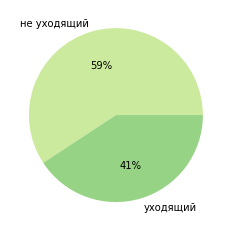

Количество строк: 432


In [120]:
data_part = data[(data['products_3'] == 1) & (data['last_activity'] == 1)]

data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
plt.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
plt.show()

print('Количество строк:', data_part.shape[0])

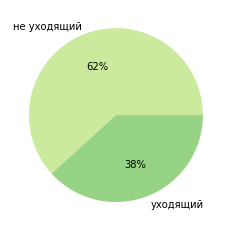

Количество строк: 447


In [121]:
data_part = data[(data['products_3'] == 1) & (data['gender_num'] == 1)]

data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
plt.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
plt.show()

print('Количество строк:', data_part.shape[0])

In [122]:
# расчет мер центр. тендеции по клиентам при группировке по признакам
measures = get_central_tendency_measures(data[(data['products_3'] == 1) & (data['last_activity'] == 1)], ['churn'], attr_list, ['median', 'mean', 'count'])
measures = get_measures_df(measures)
measures

,attr,median_0,median_1,mean_0,mean_1,count_0,count_1,diff,attr_value
23,equity_8,0.0,1.0,0.406032,1.000000,431.0,1.0,2.462857,1
17,equity_2,0.0,0.0,0.429306,0.209302,389.0,43.0,2.051128,0
15,equity_0,0.0,0.0,0.416465,0.210526,413.0,19.0,1.978208,0
16,equity_1,0.0,0.0,0.421446,0.225806,401.0,31.0,1.866405,0
22,equity_7,0.0,1.0,0.404206,0.750000,428.0,4.0,1.855491,1
8,city_Рыбинск,0.0,0.0,0.425641,0.238095,390.0,42.0,1.787692,0
21,equity_6,0.0,1.0,0.400000,0.666667,420.0,12.0,1.666667,1
9,city_Ярославль,0.0,0.0,0.280488,0.437143,82.0,350.0,1.558509,1
20,equity_5,0.0,1.0,0.357377,0.527559,305.0,127.0,1.476197,1
3,credit_card,0.0,0.0,0.444444,0.307692,315.0,117.0,1.444444,0


Есть разница по признакам баллов недвижимости, а также по городу Ярославль - в 1.6 раз. Категории по баллам недвижимости 6,7,8 небольшие, а по городу это большая категория.

In [123]:
# расчет мер центр. тендеции по клиентам при группировке по признаку оттока
measures = get_central_tendency_measures_churn(data[(data['products_3'] == 1) & (data['last_activity'] == 1)], ['churn'], ['score', 'balance', 'est_salary', 'age'], ['median', 'mean'])
measures = get_measures_df_churn(measures)
measures

,attr,median_0,median_1,mean_0,mean_1,diff,diff_churn
2,est_salary,93835.01,121440.785,1.134674e+05,1.493906e+05,1.316595,1.316595
1,balance,552746.10,913554.180,1.000312e+06,1.162114e+06,1.161751,1.161751
0,score,809.50,865.000,8.250508e+02,8.589943e+02,1.041141,1.041141
3,age,46.00,41.000,4.886719e+01,4.399432e+01,1.110761,0.900283


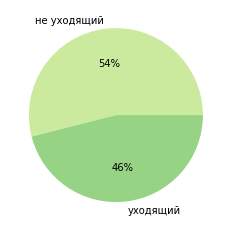

Количество строк: 339


In [124]:
data_part = data[(data['products_3'] == 1) & (data['last_activity'] == 1) & (data['equity_0'] == 0) & (data['equity_1'] == 0) & (data['equity_2'] == 0)]

data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
plt.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
plt.show()

print('Количество строк:', data_part.shape[0])

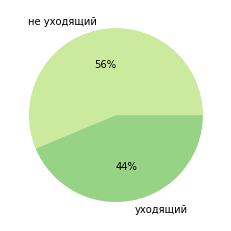

Количество строк: 350


In [125]:
data_part = data[(data['products_3'] == 1) & (data['last_activity'] == 1) & (data['city_Ярославль'] == 1) ]

data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
plt.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
plt.show()

print('Количество строк:', data_part.shape[0])

Процент уходящих небольшой по 3 продуктам, last_activity и Ярославлю.

In [126]:
# расчет мер центр. тендеции по клиентам при группировке по признакам
measures = get_central_tendency_measures(data[(data['products_3'] == 1) & (data['gender_num'] == 1)], ['churn'], attr_list, ['median', 'mean', 'count'])
measures = get_measures_df(measures)
measures

,attr,median_0,median_1,mean_0,mean_1,count_0,count_1,diff,attr_value
23,equity_8,0.0,1.0,0.381166,1.000000,446.0,1.0,2.623529,1
15,equity_0,0.0,0.0,0.395181,0.218750,415.0,32.0,1.806540,0
17,equity_2,0.0,0.0,0.396088,0.236842,409.0,38.0,1.672372,0
4,last_activity,0.0,0.0,0.324627,0.469274,268.0,179.0,1.445579,1
3,credit_card,0.0,0.0,0.437500,0.308901,256.0,191.0,1.416314,0
21,equity_6,0.0,1.0,0.376744,0.529412,430.0,17.0,1.405229,1
20,equity_5,0.0,0.0,0.345161,0.467153,310.0,137.0,1.353435,1
8,city_Рыбинск,0.0,0.0,0.402204,0.297619,363.0,84.0,1.351405,0
9,city_Ярославль,0.0,0.0,0.308333,0.409786,120.0,327.0,1.329035,1
24,equity_9,0.0,0.5,0.382022,0.500000,445.0,2.0,1.308824,1


In [127]:
# расчет мер центр. тендеции по клиентам при группировке по признаку оттока
measures = get_central_tendency_measures_churn(data[(data['products_3'] == 1) & (data['gender_num'] == 1)], ['churn'], ['score', 'balance', 'est_salary', 'age'], ['median', 'mean'])
measures = get_measures_df_churn(measures)
measures

,attr,median_0,median_1,mean_0,mean_1,diff,diff_churn
1,balance,597507.090,942634.785,1.131352e+06,1.210108e+06,1.069612,1.069612
3,age,40.000,42.000,4.132246e+01,4.373099e+01,1.058286,1.058286
2,est_salary,105968.915,121907.610,1.385657e+05,1.437916e+05,1.037715,1.037715
0,score,816.000,864.000,8.285399e+02,8.539708e+02,1.030694,1.030694


Нет больших разниц, далее может не углубляться в признаки.

###### Анализ по активности

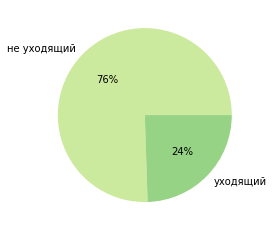

Количество строк: 5215


In [128]:
data_part = data[(data['last_activity'] == 1)]

data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
plt.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
plt.show()
print('Количество строк:', data_part.shape[0])

Процент уходящих небольшой, но строк 5215, рассмотрим по признакам подробнее

In [129]:
# расчет мер центр. тендеции по клиентам при группировке по признакам
measures = get_central_tendency_measures(data[data['last_activity'] == 1], ['churn'], attr_list, ['median', 'mean', 'count'])
measures = get_measures_df(measures)
measures

,attr,median_0,median_1,mean_0,mean_1,count_0,count_1,diff,attr_value
15,equity_0,0.0,0.0,0.322403,0.034212,3812.0,1403.0,9.423569,0
10,products_1,0.0,0.0,0.324090,0.088420,3462.0,1753.0,3.665355,0
24,equity_9,0.0,1.0,0.244385,0.666667,5209.0,6.0,2.727939,1
22,equity_7,0.0,1.0,0.241045,0.640000,5165.0,50.0,2.655100,1
13,products_4,0.0,1.0,0.220616,0.558824,4841.0,374.0,2.533019,1
20,equity_5,0.0,0.0,0.201902,0.423762,4205.0,1010.0,2.098847,1
21,equity_6,0.0,0.0,0.240679,0.478261,5123.0,92.0,1.987129,1
16,equity_1,0.0,0.0,0.253892,0.135678,4817.0,398.0,1.871281,0
23,equity_8,0.0,0.0,0.244427,0.454545,5204.0,11.0,1.859634,1
3,credit_card,0.0,0.0,0.350716,0.191643,1745.0,3470.0,1.830054,0


Есть разница в 9 раз по тем, у кого не 0 баллов собственности и 0, разница в 3 раза по тем, у кого более 1 продукта и 1 продукт.

In [130]:
# расчет мер центр. тендеции по клиентам при группировке по признаку оттока
measures = get_central_tendency_measures_churn(data[(data['last_activity'] == 1)], ['churn'], ['score', 'balance', 'est_salary', 'age'], ['median', 'mean'])
measures = get_measures_df_churn(measures)
measures

,attr,median_0,median_1,mean_0,mean_1,diff,diff_churn
1,balance,450796.475,805790.07,727424.311963,1.186077e+06,1.630515,1.630515
2,est_salary,115880.785,127673.73,146132.390297,1.544882e+05,1.057180,1.057180
0,score,835.000,870.00,839.740477,8.685168e+02,1.034268,1.034268
3,age,40.000,38.00,43.378111,4.036179e+01,1.074732,0.930464


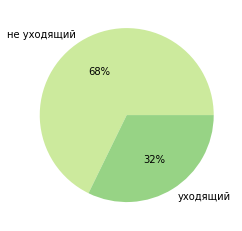

Количество строк: 3812


In [131]:
data_part = data[(data['last_activity'] == 1) & (data['equity_0'] == 0)]

data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
plt.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
plt.show()
print('Количество строк:', data_part.shape[0])

Процент уходящих небольшой, данных 3912 строк, рассмотрим по признакам подробнее.

In [132]:
# расчет мер центр. тендеции по клиентам при группировке по признакам
measures = get_central_tendency_measures(data[(data['last_activity'] == 1) & (data['equity_0'] == 0)], ['churn'], attr_list, ['median', 'mean', 'count'])
measures = get_measures_df(measures)
measures

,attr,median_0,median_1,mean_0,mean_1,count_0,count_1,diff,attr_value
16,equity_1,0.0,0.0,0.344171,0.135678,3414.0,398.0,2.536668,0
1,age,0.5,0.0,0.500000,0.200000,2.0,5.0,2.500000,0
24,equity_9,0.0,1.0,0.321860,0.666667,3806.0,6.0,2.071293,1
22,equity_7,0.0,1.0,0.318182,0.640000,3762.0,50.0,2.011429,1
13,products_4,0.0,1.0,0.297274,0.560440,3448.0,364.0,1.885264,1
6,gender_num,0.0,0.0,0.241709,0.410538,1990.0,1822.0,1.698483,1
10,products_1,0.0,0.0,0.346044,0.210526,3147.0,665.0,1.643708,0
17,equity_2,0.0,0.0,0.338156,0.216599,3318.0,494.0,1.561204,0
3,credit_card,0.0,0.0,0.408904,0.268707,1460.0,2352.0,1.521744,0
21,equity_6,0.0,0.0,0.318548,0.478261,3720.0,92.0,1.501376,1


Есть разница по признаку не 1 балла собственности, разница по возрасту.

In [133]:
# расчет мер центр. тендеции по клиентам при группировке по признаку оттока
measures = get_central_tendency_measures_churn(data[(data['last_activity'] == 1) & (data['equity_0'] == 0)], ['churn'], ['score', 'balance', 'est_salary', 'age'], ['median', 'mean'])
measures = get_measures_df_churn(measures)
measures

,attr,median_0,median_1,mean_0,mean_1,diff,diff_churn
1,balance,475647.73,831172.11,766684.820012,1.222162e+06,1.594087,1.594087
2,est_salary,94871.81,128975.96,113255.769938,1.559132e+05,1.376647,1.376647
0,score,823.00,872.00,830.877274,8.700976e+02,1.047204,1.047204
3,age,41.00,37.00,44.004646,4.035639e+01,1.090401,0.917094


Есть разница по балансу.

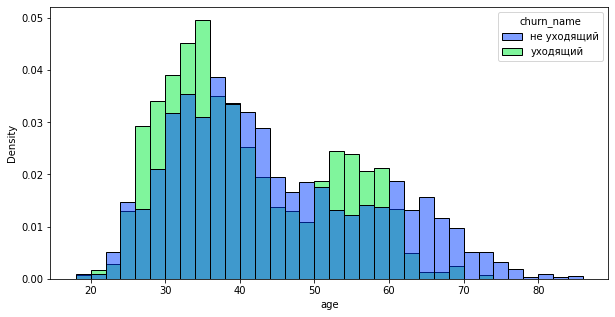

In [134]:
# гистограмма по возрасту в разрезе уходящих/не уходящих
plt.figure(figsize=(10, 5))
with plt.style.context('seaborn-bright'):
    sns.histplot(data=data[(data['last_activity'] == 1) & (data['equity_0'] == 0)], x="age", hue="churn_name", hue_order=["не уходящий", "уходящий"], stat="density", common_norm=False, binwidth=2) 

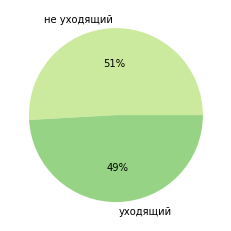

Количество строк: 444


In [135]:
data_part = data[(data['last_activity'] == 1) & (data['equity_0'] == 0) & (data['equity_1'] == 0)  & (data['products_1'] == 0)  & (data['age'] >= 52) & (data['age'] <= 60)]

data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
plt.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
plt.show()
print('Количество строк:', data_part.shape[0])

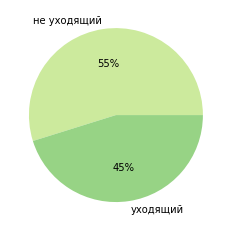

Количество строк: 934


In [136]:
data_part = data[(data['last_activity'] == 1) & (data['equity_0'] == 0) & (data['equity_1'] == 0) & (data['age'] >= 26) & (data['age'] <= 34)]

data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
plt.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
plt.show()
print('Количество строк:', data_part.shape[0])

Процент уходящих 45%, данных 934 строки, рассмотрим по признакам подробнее.

In [137]:
# расчет мер центр. тендеции по клиентам при группировке по признакам
measures = get_central_tendency_measures(data[(data['last_activity'] == 1) & (data['equity_0'] == 0) & (data['equity_1'] == 0) & (data['age'] >= 26) & (data['age'] <= 34)], ['churn'], attr_list, ['median', 'mean', 'count'])
measures = get_measures_df(measures)
measures

,attr,median_0,median_1,mean_0,mean_1,count_0,count_1,diff,attr_value
23,equity_8,0.0,1.0,0.450644,1.000000,932.0,2.0,2.219048,1
22,equity_7,0.0,1.0,0.444444,0.875000,918.0,16.0,1.968750,1
17,equity_2,0.0,0.0,0.483146,0.263158,801.0,133.0,1.835955,0
3,credit_card,1.0,0.0,0.592920,0.371429,339.0,595.0,1.596324,0
24,equity_9,0.0,1.0,0.451128,0.666667,931.0,3.0,1.477778,1
13,products_4,0.0,1.0,0.432367,0.603774,828.0,106.0,1.396437,1
6,gender_num,0.0,1.0,0.375309,0.510397,405.0,529.0,1.359939,1
10,products_1,0.0,0.0,0.469466,0.358108,786.0,148.0,1.310961,0
12,products_3,0.0,1.0,0.440936,0.569620,855.0,79.0,1.291844,1
20,equity_5,0.0,1.0,0.418462,0.528169,650.0,284.0,1.262169,1


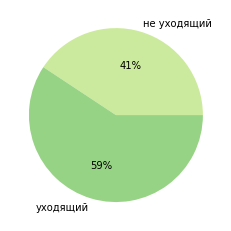

Количество строк: 339


In [138]:
data_part = data[(data['last_activity'] == 1) & (data['equity_0'] == 0) & (data['equity_1'] == 0) & (data['age'] >= 26) & (data['age'] <= 34) & (data['credit_card'] == 0)]

data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
plt.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
plt.show()
print('Количество строк:', data_part.shape[0])

###### Анализ по кредитному рейтингу

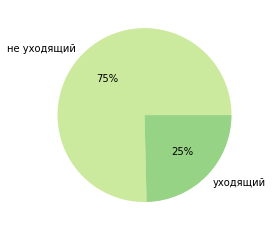

Количество строк: 4203


In [139]:
data_part = data[(data['score'] >= 820) & (data['score'] <= 900)]

data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
plt.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
plt.show()
print('Количество строк:', data_part.shape[0])

Процент уходящих небольшой, но строк 5215, рассмотрим по признакам подробнее

In [140]:
# расчет мер центр. тендеции по клиентам при группировке по признакам
measures = get_central_tendency_measures(data[(data['score'] >= 820) & (data['score'] <= 900)], ['churn'], attr_list, ['median', 'mean', 'count'])
measures = get_measures_df(measures)
measures

,attr,median_0,median_1,mean_0,mean_1,count_0,count_1,diff,attr_value
15,equity_0,0.0,0.0,0.281224,0.051562,3563.0,640.0,5.454035,0
4,last_activity,0.0,0.0,0.121563,0.367606,2073.0,2130.0,3.023994,1
10,products_1,0.0,0.0,0.290634,0.120438,3107.0,1096.0,2.413143,0
13,products_4,0.0,1.0,0.223620,0.532468,3895.0,308.0,2.381126,1
22,equity_7,0.0,0.0,0.243744,0.468085,4156.0,47.0,1.920397,1
16,equity_1,0.0,0.0,0.253425,0.137931,3942.0,261.0,1.837329,0
6,gender_num,0.0,0.0,0.179853,0.317398,2174.0,2029.0,1.764764,1
24,equity_9,0.0,0.0,0.245949,0.428571,4196.0,7.0,1.742525,1
21,equity_6,0.0,0.0,0.242881,0.393617,4109.0,94.0,1.620614,1
20,equity_5,0.0,0.0,0.219152,0.331041,3185.0,1018.0,1.510554,1


In [141]:
# расчет мер центр. тендеции по клиентам при группировке по признаку оттока
measures = get_central_tendency_measures_churn(data[(data['score'] >= 820) & (data['score'] <= 920) ], ['churn'], ['score', 'balance', 'est_salary', 'age'], ['median', 'mean'])
measures = get_measures_df_churn(measures)
measures

,attr,median_0,median_1,mean_0,mean_1,diff,diff_churn
1,balance,544374.82,789966.010,749891.964631,1.033187e+06,1.377782,1.377782
2,est_salary,117204.12,126501.205,133615.241921,1.411591e+05,1.056460,1.056460
0,score,875.00,870.000,872.176355,8.702849e+02,1.002173,0.997831
3,age,41.00,38.000,43.464557,4.067451e+01,1.068594,0.935809


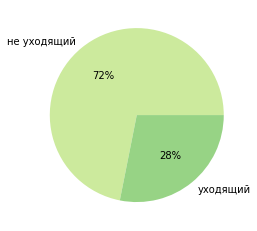

Количество строк: 3563


In [142]:
data_part = data[(data['score'] >= 820) & (data['score'] <= 900) & (data['equity_0'] == 0)]

data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
plt.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
plt.show()
print('Количество строк:', data_part.shape[0])

In [143]:
# расчет мер центр. тендеции по клиентам при группировке по признакам
measures = get_central_tendency_measures(data[(data['score'] >= 820) & (data['score'] <= 900) & (data['equity_0'] == 0)], ['churn'], attr_list, ['median', 'mean', 'count'])
measures = get_measures_df(measures)
measures

,attr,median_0,median_1,mean_0,mean_1,count_0,count_1,diff,attr_value
4,last_activity,0.0,0.0,0.135823,0.424276,1767.0,1796.0,3.123733,1
16,equity_1,0.0,0.0,0.292550,0.137931,3302.0,261.0,2.120987,0
13,products_4,0.0,1.0,0.257669,0.534653,3260.0,303.0,2.074965,1
1,age,0.0,0.0,0.333333,0.166667,3.0,6.0,2.000000,0
6,gender_num,0.0,0.0,0.198294,0.373444,1876.0,1687.0,1.883282,1
22,equity_7,0.0,0.0,0.278726,0.468085,3516.0,47.0,1.679375,1
23,equity_8,0.0,0.0,0.281532,0.181818,3552.0,11.0,1.548423,0
24,equity_9,0.0,0.0,0.280934,0.428571,3556.0,7.0,1.525526,1
3,credit_card,0.0,0.0,0.352941,0.237838,1343.0,2220.0,1.483957,0
10,products_1,0.0,0.0,0.297793,0.202265,2945.0,618.0,1.472288,0


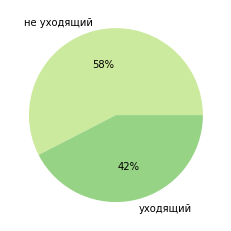

Количество строк: 1796


In [144]:
data_part = data[(data['score'] >= 820) & (data['score'] <= 900) & (data['equity_0'] == 0) & (data['last_activity'] == 1)]

data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
plt.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
plt.show()
print('Количество строк:', data_part.shape[0])

###### Анализ по балансу

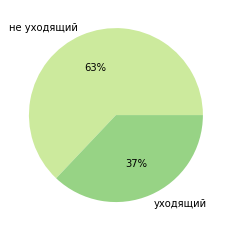

Количество строк: 2167


In [145]:
data_part = data[(data['balance'] >= 900000)]

data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
plt.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
plt.show()
print('Количество строк:', data_part.shape[0])

Процент уходящих 37%, строк 2167, рассмотрим по признакам подробнее.

In [146]:
# расчет мер центр. тендеции по клиентам при группировке по признакам
measures = get_central_tendency_measures(data[(data['balance'] >=  900000)], ['churn'], attr_list, ['median', 'mean', 'count'])
measures = get_measures_df(measures)
measures

,attr,median_0,median_1,mean_0,mean_1,count_0,count_1,diff,attr_value
16,equity_1,0.0,0.0,0.372960,0.136364,2145.0,22.0,2.735043,0
14,products_5,0.0,1.0,0.368519,1.000000,2160.0,7.0,2.713568,1
24,equity_9,0.0,1.0,0.369686,1.000000,2164.0,3.0,2.705000,1
15,equity_0,0.0,1.0,0.369977,1.000000,2165.0,2.0,2.702871,1
13,products_4,0.0,1.0,0.314969,0.810700,1924.0,243.0,2.573904,1
4,last_activity,0.0,1.0,0.221680,0.503937,1024.0,1143.0,2.273267,1
10,products_1,0.0,0.0,0.394191,0.179916,1928.0,239.0,2.190968,0
23,equity_8,0.0,1.0,0.369857,0.750000,2163.0,4.0,2.027813,1
6,gender_num,0.0,0.0,0.255218,0.479784,1054.0,1113.0,1.879899,1
21,equity_6,0.0,1.0,0.364534,0.682927,2126.0,41.0,1.873423,1


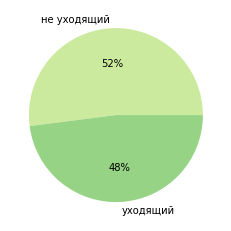

Количество строк: 1113


In [147]:
data_part = data[(data['balance'] >= 900000) & (data['gender_num'] == 1) ]

data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
plt.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
plt.show()
print('Количество строк:', data_part.shape[0])

Рассмотрим по признаку пола:

In [148]:
# расчет мер центр. тендеции по клиентам при группировке по признакам
measures = get_central_tendency_measures(data[(data['balance'] >=  900000) & (data['gender_num'] == 1)], ['churn'], attr_list, ['median', 'mean', 'count'])
measures = get_measures_df(measures)
measures

,attr,median_0,median_1,mean_0,mean_1,count_0,count_1,diff,attr_value
16,equity_1,0.0,0.0,0.483197,0.166667,1101.0,12.0,2.899183,0
14,products_5,0.0,1.0,0.477908,1.000000,1109.0,4.0,2.092453,1
24,equity_9,0.0,1.0,0.478378,1.000000,1110.0,3.0,2.090395,1
15,equity_0,0.0,1.0,0.478848,1.000000,1111.0,2.0,2.088346,1
10,products_1,1.0,0.0,0.508629,0.257812,985.0,128.0,1.972866,0
13,products_4,0.0,1.0,0.425466,0.836735,966.0,147.0,1.966632,1
4,last_activity,0.0,1.0,0.333333,0.614853,534.0,579.0,1.844560,1
22,equity_7,0.0,1.0,0.475455,0.846154,1100.0,13.0,1.779673,1
21,equity_6,0.0,1.0,0.474701,0.692308,1087.0,26.0,1.458408,1
23,equity_8,0.0,1.0,0.479279,0.666667,1110.0,3.0,1.390977,1


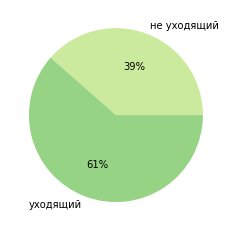

Количество строк: 579


In [149]:
data_part = data[(data['balance'] >= 900000) & (data['gender_num'] == 1) &  (data['last_activity'] == 1)]

data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
plt.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
plt.show()
print('Количество строк:', data_part.shape[0])

Процент уходящих 61% с балансом от 900 тыс, мужчин, с признаком активности.

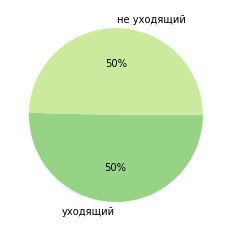

Количество строк: 1143


In [150]:
data_part = data[(data['balance'] >= 900000) &  (data['last_activity'] == 1)]

data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
plt.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
plt.show()
print('Количество строк:', data_part.shape[0])

In [151]:
# расчет мер центр. тендеции по клиентам при группировке по признакам
measures = get_central_tendency_measures(data[(data['balance'] >=  900000) & (data['last_activity'] == 1)], ['churn'], attr_list, ['median', 'mean', 'count'])
measures = get_measures_df(measures)
measures

,attr,median_0,median_1,mean_0,mean_1,count_0,count_1,diff,attr_value
1,age,0.5,0.0,0.500000,0.200000,2.0,5.0,2.500000,0
16,equity_1,1.0,0.0,0.507529,0.214286,1129.0,14.0,2.368468,0
14,products_5,1.0,1.0,0.501757,1.000000,1138.0,5.0,1.992995,1
24,equity_9,1.0,1.0,0.502632,1.000000,1140.0,3.0,1.989529,1
15,equity_0,1.0,1.0,0.503067,1.000000,1141.0,2.0,1.987805,1
10,products_1,1.0,0.0,0.529873,0.286885,1021.0,122.0,1.846985,0
22,equity_7,0.5,1.0,0.500000,0.846154,1130.0,13.0,1.692308,1
13,products_4,0.0,1.0,0.461145,0.757576,978.0,165.0,1.642814,1
6,gender_num,0.0,1.0,0.390071,0.614853,564.0,579.0,1.576260,1
17,equity_2,1.0,0.0,0.515977,0.341772,1064.0,79.0,1.509712,0


Text(0, 0.5, 'Доля, %')

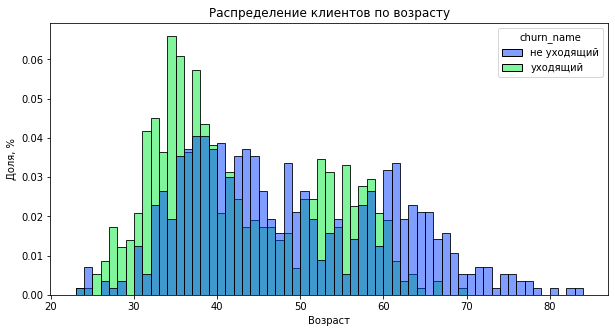

In [152]:
# гистограмма по возрасту в разрезе уходящих/не уходящих
plt.figure(figsize=(10, 5))
with plt.style.context('seaborn-bright'):
    sns.histplot(data=data[(data['balance'] >=  900000) & (data['last_activity'] == 1)], x="age", hue="churn_name", hue_order=["не уходящий", "уходящий"], stat="density", common_norm=False, binwidth=1) 
plt.title('Распределение клиентов по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Доля, %')

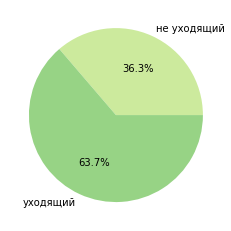

Количество строк: 634


In [153]:
data_part = data[(data['balance'] >= 900000) &  (data['last_activity'] == 1) & ((data['age'].between(25, 38)) | (data['age'].between(52, 60)))]

data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
plt.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.1f%%')
plt.show()
print('Количество строк:', data_part.shape[0])

###### Анализ по баллам собственности

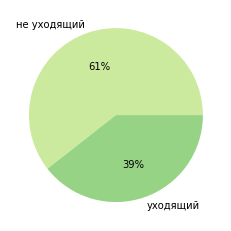

Количество строк: 241


In [154]:
data_part = data[(data['equity_7'] == 1) | (data['equity_6'] == 1)]

data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
plt.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
plt.show()
print('Количество строк:', data_part.shape[0])

In [155]:
# расчет мер центр. тендеции по клиентам при группировке по признакам
measures = get_central_tendency_measures(data[(data['equity_7'] == 1) | (data['equity_6'] == 1)], ['churn'], attr_list, ['median', 'mean', 'count'])
measures = get_measures_df(measures)
measures

,attr,median_0,median_1,mean_0,mean_1,count_0,count_1,diff,attr_value
4,last_activity,0.0,1.0,0.191919,0.535211,99.0,142.0,2.788732,1
7,city_Ростов,0.0,0.0,0.432836,0.200000,201.0,40.0,2.164179,0
13,products_4,0.0,1.0,0.336735,0.644444,196.0,45.0,1.913805,1
6,gender_num,0.0,0.0,0.271028,0.492537,107.0,134.0,1.817293,1
9,city_Ярославль,0.0,0.0,0.297872,0.455782,94.0,147.0,1.530126,1
3,credit_card,0.0,0.0,0.494845,0.326389,97.0,144.0,1.516122,0
11,products_2,0.0,0.0,0.455285,0.330508,123.0,118.0,1.377528,0
10,products_1,0.0,0.0,0.414141,0.302326,198.0,43.0,1.369852,0
21,equity_6,0.0,0.0,0.462500,0.360248,80.0,161.0,1.283836,0
22,equity_7,0.0,0.0,0.360248,0.462500,161.0,80.0,1.283836,1


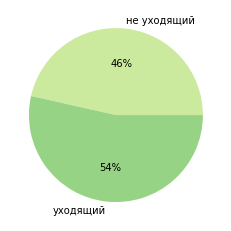

Количество строк: 142


In [156]:
data_part = data[((data['equity_7'] == 1) | (data['equity_6'] == 1)) & (data['last_activity'] == 1)]

data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
plt.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
plt.show()
print('Количество строк:', data_part.shape[0])

Слишком маленький сегмент.

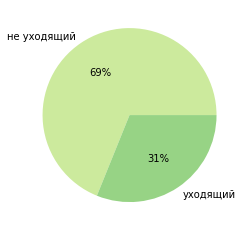

Количество строк: 2156


In [157]:
data_part = data[(data['equity_7'] == 1) | (data['equity_6'] == 1) | (data['equity_5'] == 1)]

data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
plt.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
plt.show()
print('Количество строк:', data_part.shape[0])

In [158]:
# расчет мер центр. тендеции по клиентам при группировке по признакам
measures = get_central_tendency_measures(data[(data['equity_7'] == 1) | (data['equity_6'] == 1) | (data['equity_5'] == 1)], ['churn'], attr_list, ['median', 'mean', 'count'])
measures = get_measures_df(measures)
measures

,attr,median_0,median_1,mean_0,mean_1,count_0,count_1,diff,attr_value
4,last_activity,0.0,0.0,0.166335,0.437500,1004.0,1152.0,2.630240,1
13,products_4,0.0,1.0,0.275489,0.635514,1942.0,214.0,2.306856,1
14,products_5,0.0,1.0,0.309912,0.714286,2149.0,7.0,2.304805,1
6,gender_num,0.0,0.0,0.205714,0.411392,1050.0,1106.0,1.999824,1
10,products_1,0.0,0.0,0.331148,0.199387,1830.0,326.0,1.660832,0
22,equity_7,0.0,0.0,0.305395,0.462500,2076.0,80.0,1.514432,1
3,credit_card,0.0,0.0,0.386005,0.259055,886.0,1270.0,1.490048,0
11,products_2,0.0,0.0,0.377030,0.267388,862.0,1294.0,1.410049,0
20,equity_5,0.0,0.0,0.394191,0.300783,241.0,1915.0,1.310548,0
9,city_Ярославль,0.0,0.0,0.267509,0.340856,871.0,1285.0,1.274187,1


In [159]:
# расчет мер центр. тендеции по клиентам при группировке по признаку оттока
measures = get_central_tendency_measures_churn(data[(data['equity_7'] == 1) | (data['equity_6'] == 1) | (data['equity_5'] == 1)], ['churn'], ['score', 'balance', 'est_salary', 'age'], ['median', 'mean'])
measures = get_measures_df_churn(measures)
measures

,attr,median_0,median_1,mean_0,mean_1,diff,diff_churn
2,est_salary,103468.79,135027.11,1.282201e+05,1.672655e+05,1.304519,1.304519
1,balance,754769.25,1024786.60,1.152836e+06,1.349249e+06,1.170374,1.170374
0,score,858.00,883.00,8.589118e+02,8.802116e+02,1.024799,1.024799
3,age,41.00,38.00,4.383232e+01,4.086736e+01,1.072551,0.932357


###### Анализ по доходу

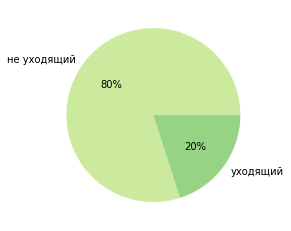

Количество строк: 5151


In [160]:
data_part = data[(data['est_salary'] >= 100000) & (data['est_salary'] <= 250000)]

data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
plt.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
plt.show()
print('Количество строк:', data_part.shape[0])

In [161]:
# расчет мер центр. тендеции по клиентам при группировке по признакам
measures = get_central_tendency_measures(data[(data['est_salary'] >= 100000) & (data['est_salary'] <= 250000)], ['churn'], attr_list, ['median', 'mean', 'count'])
measures = get_measures_df(measures)
measures

,attr,median_0,median_1,mean_0,mean_1,count_0,count_1,diff,attr_value
15,equity_0,0.0,0.0,0.272853,0.029412,3621.0,1530.0,9.276995,0
13,products_4,0.0,1.0,0.172772,0.776371,4914.0,237.0,4.493626,1
10,products_1,0.0,0.0,0.277626,0.062771,3303.0,1848.0,4.422876,0
24,equity_9,0.0,1.0,0.199961,0.800000,5146.0,5.0,4.000777,1
14,products_5,0.0,1.0,0.199689,0.538462,5138.0,13.0,2.696506,1
23,equity_8,0.0,0.5,0.199961,0.500000,5141.0,10.0,2.500486,1
4,last_activity,0.0,0.0,0.118631,0.278515,2512.0,2639.0,2.347747,1
21,equity_6,0.0,0.0,0.196967,0.445946,5077.0,74.0,2.264068,1
22,equity_7,0.0,0.0,0.199101,0.424242,5118.0,33.0,2.130788,1
20,equity_5,0.0,0.0,0.166069,0.349896,4185.0,966.0,2.106931,1


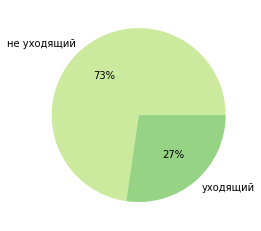

Количество строк: 3621


In [162]:
data_part = data[(data['est_salary'] >= 100000) & (data['est_salary'] <= 250000) & (data['equity_0'] == 0) ]

data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
plt.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
plt.show()
print('Количество строк:', data_part.shape[0])

In [163]:
# расчет мер центр. тендеции по клиентам при группировке по признакам
measures = get_central_tendency_measures(data[(data['est_salary'] >= 100000) & (data['est_salary'] <= 250000) & (data['equity_0'] == 0)], ['churn'], attr_list, ['median', 'mean', 'count'])
measures = get_measures_df(measures)
measures

,attr,median_0,median_1,mean_0,mean_1,count_0,count_1,diff,attr_value
13,products_4,0.0,1.0,0.238643,0.774892,3390.0,231.0,3.247074,1
24,equity_9,0.0,1.0,0.272124,0.800000,3616.0,5.0,2.939837,1
4,last_activity,0.0,0.0,0.150219,0.397329,1824.0,1797.0,2.644992,1
16,equity_1,0.0,0.0,0.287809,0.132184,3273.0,348.0,2.177340,0
10,products_1,0.0,0.0,0.300813,0.149477,2952.0,669.0,2.012439,0
14,products_5,0.0,1.0,0.271896,0.538462,3608.0,13.0,1.980397,1
23,equity_8,0.0,0.5,0.272224,0.500000,3611.0,10.0,1.836724,1
6,gender_num,0.0,0.0,0.198744,0.342246,1751.0,1870.0,1.722048,1
17,equity_2,0.0,0.0,0.289990,0.169261,3107.0,514.0,1.713276,0
21,equity_6,0.0,0.0,0.269242,0.445946,3547.0,74.0,1.656304,1


In [164]:
# расчет мер центр. тендеции по клиентам при группировке по признаку оттока
measures = get_central_tendency_measures_churn(data[(data['est_salary'] >= 100000) & (data['est_salary'] <= 250000) & (data['equity_0'] == 0)], ['churn'], ['score', 'balance', 'est_salary', 'age'], ['median', 'mean'])
measures = get_measures_df_churn(measures)
measures

,attr,median_0,median_1,mean_0,mean_1,diff,diff_churn
1,balance,568588.76,985470.945,795578.466498,1.124300e+06,1.413185,1.413185
0,score,839.00,874.000,842.895936,8.700779e+02,1.032248,1.032248
2,est_salary,143387.51,150231.170,150837.475727,1.556170e+05,1.031686,1.031686
3,age,41.00,39.000,42.401443,4.115587e+01,1.030265,0.970624


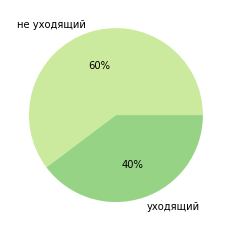

Количество строк: 1797


In [165]:
data_part = data[(data['est_salary'] >= 100000) & (data['est_salary'] <= 250000) & (data['equity_0'] == 0) & (data['last_activity'] == 1)]

data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
plt.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
plt.show()
print('Количество строк:', data_part.shape[0])

###### Анализ по наличию кредитной карты

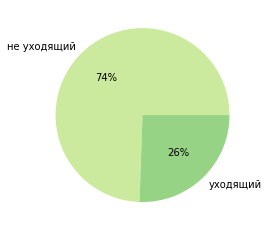

Количество строк: 3189


In [166]:
data_part = data[(data['credit_card'] == 0)]

data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
plt.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
plt.show()
print('Количество строк:', data_part.shape[0])

In [167]:
# расчет мер центр. тендеции по клиентам при группировке по признакам
measures = get_central_tendency_measures(data[(data['credit_card'] == 0)], ['churn'], attr_list, ['median', 'mean', 'count'])
measures = get_measures_df(measures)
measures

,attr,median_0,median_1,mean_0,mean_1,count_0,count_1,diff,attr_value
10,products_1,0.0,0.0,0.289474,0.050773,2736.0,453.0,5.701373,0
15,equity_0,0.0,0.0,0.295156,0.055133,2663.0,526.0,5.353516,0
24,equity_9,0.0,1.0,0.254631,1.000000,3185.0,4.0,3.927250,1
4,last_activity,0.0,0.0,0.140582,0.350716,1444.0,1745.0,2.494751,1
16,equity_1,0.0,0.0,0.264883,0.115578,2990.0,199.0,2.291813,0
22,equity_7,0.0,1.0,0.252772,0.531250,3157.0,32.0,2.101700,1
21,equity_6,0.0,0.0,0.250960,0.476923,3124.0,65.0,1.900392,1
6,gender_num,0.0,0.0,0.189820,0.350729,1886.0,1303.0,1.847696,1
20,equity_5,0.0,0.0,0.217083,0.372624,2400.0,789.0,1.716500,1
13,products_4,0.0,0.0,0.247202,0.423841,3038.0,151.0,1.714553,1


In [168]:
# расчет мер центр. тендеции по клиентам при группировке по признаку оттока
measures = get_central_tendency_measures_churn(data[(data['credit_card'] == 0)], ['churn'], ['score', 'balance', 'est_salary', 'age'], ['median', 'mean'])
measures = get_measures_df_churn(measures)
measures

,attr,median_0,median_1,mean_0,mean_1,diff,diff_churn
1,balance,544729.38,969489.165,861379.451811,1.282983e+06,1.489451,1.489451
2,est_salary,111983.03,131346.930,135936.664684,1.538307e+05,1.131635,1.131635
0,score,851.00,878.000,851.864364,8.748344e+02,1.026964,1.026964
3,age,43.00,39.000,45.847515,4.218160e+01,1.086908,0.920041


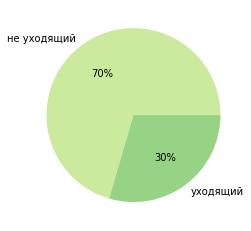

Количество строк: 2663


In [169]:
data_part = data[(data['credit_card'] == 0) & (data['equity_0'] == 0)]

data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
plt.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
plt.show()
print('Количество строк:', data_part.shape[0])

###### Выводы

~~Найдены следующие сегменты с оттоком клиентов с процентом отточных клиентов от 41% до 82%:~~

1. Количество строк: 323
2. Количество строк: 339
3. Количество строк: 350
4. Количество строк: 444
5. Количество строк: 339
6. Количество строк: 1796
7. Количество строк: 579
8. Количество строк: 634
9. Количество строк: 432


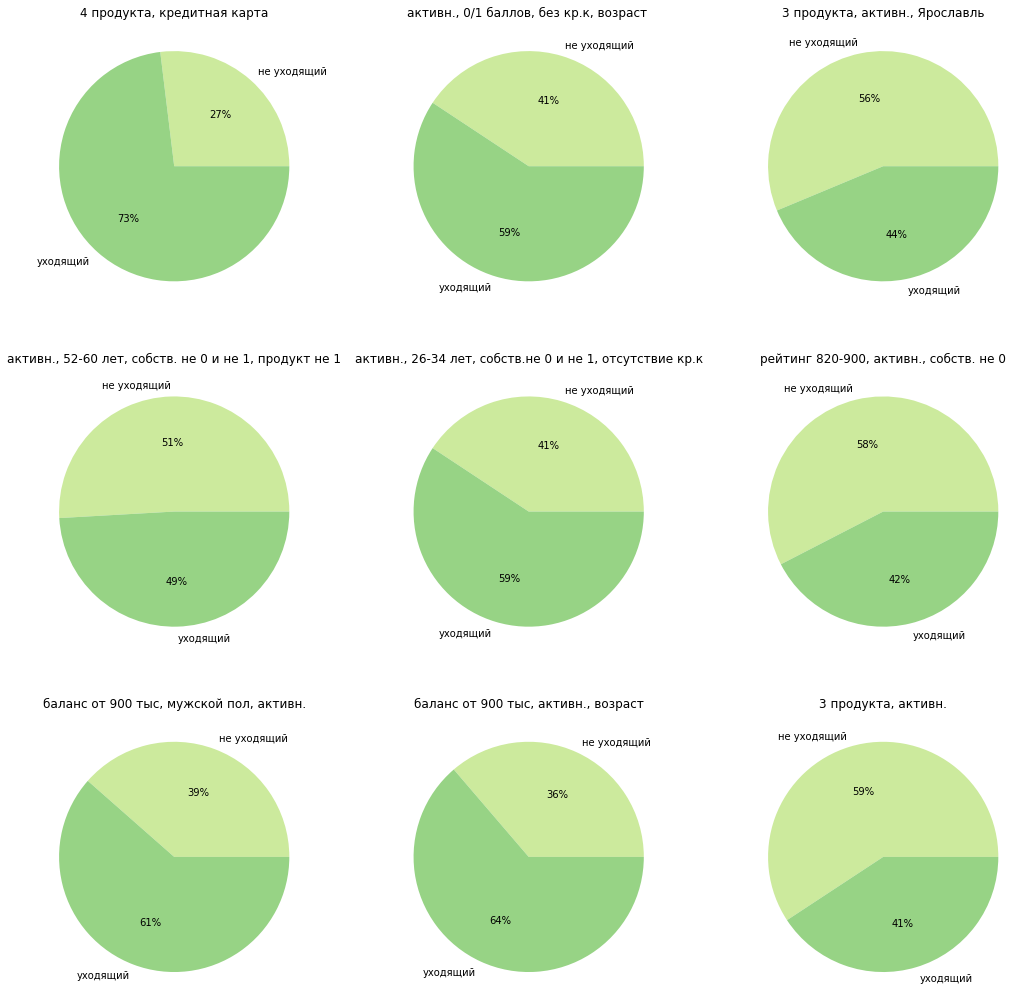

In [170]:
fig, axes = plt.subplots(3, 3, figsize=(18,18))

ax = axes[0, 0]
data_part = data[((data['products_4'] == 1)) & (data['credit_card'] == 1) ]
data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
ax.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
ax.set(ylabel='', title='4 продукта, кредитная карта', aspect='equal')
print('1. Количество строк:', data_part.shape[0])

ax = axes[0, 1]
# data_part = data[(data['balance'] >= 1000000) & (data['products_4'] >= 1)]
data_part = data[(data['last_activity'] == 1) & (data['equity_0'] == 0) & (data['equity_1'] == 0) & (data['age'] >= 26) & (data['age'] <= 34) & (data['credit_card'] == 0)]
data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
ax.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
# ax.set(ylabel='', title='4 продукта, баланс от 1 млн.', aspect='equal')
ax.set(ylabel='', title='активн., 0/1 баллов, без кр.к, возраст ', aspect='equal')
print('2. Количество строк:', data_part.shape[0])

ax = axes[0, 2]
data_part = data[(data['products_3'] == 1) & (data['last_activity'] == 1) & (data['city_Ярославль'] == 1) ]
data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
ax.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
ax.set(ylabel='', title='3 продукта, активн., Ярославль', aspect='equal')
print('3. Количество строк:', data_part.shape[0])

ax = axes[1, 0]
data_part = data[(data['last_activity'] == 1) & (data['equity_0'] == 0) & (data['equity_1'] == 0)  & (data['products_1'] == 0)  & (data['age'] >= 52) & (data['age'] <= 60)]
data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
ax.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
ax.set(ylabel='', title='активн., 52-60 лет, собств. не 0 и не 1, продукт не 1', aspect='equal')
print('4. Количество строк:', data_part.shape[0])

ax = axes[1, 1]
data_part = data[(data['last_activity'] == 1) & (data['equity_0'] == 0) & (data['equity_1'] == 0) & (data['age'] >= 26) & (data['age'] <= 34) & (data['credit_card'] == 0)]
data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
ax.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
ax.set(ylabel='', title='активн., 26-34 лет, собств.не 0 и не 1, отсутствие кр.к', aspect='equal')
print('5. Количество строк:', data_part.shape[0])

ax = axes[1, 2]
data_part = data[(data['score'] >= 820) & (data['score'] <= 900) & (data['equity_0'] == 0) & (data['last_activity'] == 1)]
data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
ax.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
ax.set(ylabel='', title='рейтинг 820-900, активн., собств. не 0', aspect='equal')
print('6. Количество строк:', data_part.shape[0])

ax = axes[2, 0]
data_part = data[(data['balance'] >= 900000) & (data['gender_num'] == 1) &  (data['last_activity'] == 1)]
data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
ax.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
ax.set(ylabel='', title='баланс от 900 тыс, мужской пол, активн.', aspect='equal')
print('7. Количество строк:', data_part.shape[0])

ax = axes[2, 1]
# data_part = data[(((data['equity_7'] == 1) | (data['equity_6'] == 1)) & (data['last_activity'] == 1))]
data_part = data[(data['balance'] >= 900000) &  (data['last_activity'] == 1) & ((data['age'].between(25, 38)) | (data['age'].between(52, 60)))]
data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
ax.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
# ax.set(ylabel='', title='баллы собств. 6 или 7, активн.', aspect='equal')
ax.set(ylabel='', title='баланс от 900 тыс, активн., возраст', aspect='equal')
print('8. Количество строк:', data_part.shape[0])

ax = axes[2, 2]
data_part = data[(data['products_3'] == 1) & (data['last_activity'] == 1)]
data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
ax.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
ax.set(ylabel='', title='3 продукта, активн.', aspect='equal')
print('9. Количество строк:', data_part.shape[0])

# fig.delaxes(ax= axes[2,2])  
# fig.delaxes(ax= axes[2,1]) 
plt.show() 

Выберем следующие три сегмента с оттоком клиентов:

1. Количество строк: 323
2. Количество строк: 1796
3. Количество строк: 579


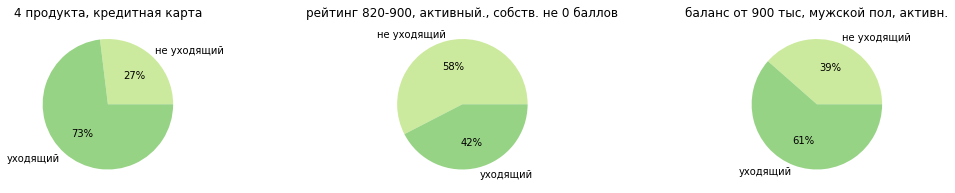

In [171]:
fig, axes = plt.subplots(1, 3, figsize=(18, 3))

ax = axes[0]
data_part = data[((data['products_4'] == 1)) & (data['credit_card'] == 1) ]
data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
ax.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
ax.set(ylabel='', title='4 продукта, кредитная карта', aspect='equal')
print('1. Количество строк:', data_part.shape[0])

ax = axes[1]
data_part = data[(data['score'] >= 820) & (data['score'] <= 900) & (data['equity_0'] == 0) & (data['last_activity'] == 1)]
data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
ax.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
ax.set(ylabel='', title='рейтинг 820-900, активный., собств. не 0 баллов', aspect='equal')
print('2. Количество строк:', data_part.shape[0])

ax = axes[2]
data_part = data[(data['balance'] >= 900000) & (data['gender_num'] == 1) &  (data['last_activity'] == 1)]
data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
ax.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
ax.set(ylabel='', title='баланс от 900 тыс, мужской пол, активн.', aspect='equal')
print('3. Количество строк:', data_part.shape[0])

plt.show() 

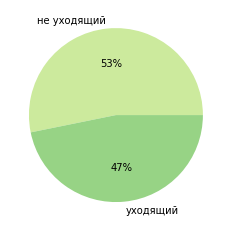

Количество строк: 2226


In [172]:
# общее количество найденных сегментов
data_part = data[( ((data['products_4'] == 1) & (data['credit_card'] == 1))
                     | ((data['score'] >= 820) & (data['score'] <= 900) & (data['equity_0'] == 0) & (data['last_activity'] == 1))
                  | ((data['balance'] >= 900000) & (data['gender_num'] == 1) &  (data['last_activity'] == 1))
)]

data_groupped = data_part.groupby(['churn_name'], as_index = False)[['user_id']].count()
plt.pie(data_groupped['user_id'], labels = data_groupped['churn_name'], colors = sns.color_palette('YlGn')[1:3], autopct='%.0f%%')
plt.show()
print('Количество строк:', data_part.shape[0])

Между найденными сегментами есть пересечения.

Рекомендации:  <br>
    
Для клиентов, у которых 4 продукта и кредитная карта, возможно, стоит предложит более выгодные условия по кредитной карте или бонусы, кэшбеки.<br>

Для клиентов с рейтингом 820-900, с баллами собственности, отличными от 0, с признаком активности, возможно, стоит предложить кредиты или вклады.<br>

Для клиентов с балансом от 900 тыс, мужчин, с признаком активности, возможно, стоит предложить выгодные вклады, программы инвестиций.


#### Выводы

Проведен анализ данных банка по клиентам, проанализированы пропуски, выявлены признаки отточных и неотточных клиентов, проверены статистические гипотезы, выделены сегменты отточных клиентов.

<b>Анализ по признакам отточных и неотточных клиентов</b>  

Выводы по проведенному анализу:
- чем больше продуктов у клиентов, тем выше процент уходящих клиентов
- чем больше баллов собственности, тем выше процент уходящих клиентов
- клиенты в возрасте примерно от 26 до 36 и от 50 до 60 - процент уходящих клиентов выше
- среди клиентов с кредитным рейтингом примерно от 820 до 910 процент уходящих клиентов выше
- много уходящих клиентов с балансом от 900 тыс
- процент уходящих среди клиентов с доходом от 100 до 200 тыс выше
- процент уходящих среди клиентов без кредитной карты выше, чем среди клиентов с кредитной
- процент уходящих клиентов среди мужчин выше, чем среди женщин
- процент уходящих клиентов среди клиентов с недавней активностью выше, чем среди клиентов без недавней активности

Неуходящие клиенты:
- с небольшим количеством баллов собственности
- с небольшим количеством продуктов
- с кредитной картой

Уходящие клиенты:
- с большим количеством баллов собственности
- с большим количеством продуктов
- возрасте от 26 до 36 и от 50 до 60
- с балансом от 900 тыс
- с доходом от 100 до 200 тыс

<b>Корреляция</b>  

Обнаружены связи между признаком оттока и следующими признаками:

слабая связь:  
- количество баллов собственности (0.35)  

очень слабая связь:
- количество продуктов (0.26)
- активность (0.26)
- кредитный рейтинг (0.23)
- пол (0.22)
- наличие кредитной карты (0.2)
- возраст (0.19)

Также обнаружены средние связи между признаками:
- количество баллов собственности и кредитный рейтинг
- количество баллов собственности и количество продуктов

<b>Статистический анализ</b>  

Проверены статистические гипотезы, по результатам которых выявлено:
- доходы уходящих и не уходящих клиентов не равны 
- признак оттока и количество продуктов (от 1 до 4) зависимы  

<b>Сегментация клиентов</b>  

Проведена сегментация клиентов, выделены следующие сегменты отточных клиентов:
- Клиенты с 4 продуктами и кредитной картой (73% отточных, размер сегмента - 323)
- Клиенты с кредитным рейтингом 820-900, с баллами собственности, отличными от 0, и с признаком недавней активности (42 % отточных, размер сегмента - 1796)
- Клиенты с балансом от 900 тыс, мужчин, с признаком недавней активности (61% отточных, размер сегмента - 579)

Рекомендации по сегментам с отточными клиентами:
- клиентам, у которых 4 продукта и кредитная карта, возможно, стоит предложит более выгодные условия по кредитной карте или бонусы, кэшбеки  
- клиентам с рейтингом 820-900, с баллами собственности, отличными от 0, с признаком активности, возможно, стоит предложить кредиты или вклады  
- клиентам с балансом от 900 тыс, мужчин, с признаком активности, возможно, стоит предложить выгодные вклады, программы инвестиций.


Презентация:  
https://disk.yandex.ru/i/0JgWGhdWMtW-uQ    
